Prepared By: Ahmad Alqaisi

# Data Reading

Starting by loading the data from the previous notebook ([preparation.ipynb](http://localhost:8888/notebooks/Binary%20Digits/DebtCollection%20_2/preparation.ipynb)) in a *pandas DataFrame* object:

In [1]:
# import required libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import squarify
from scipy import stats

from sklearn.preprocessing import MinMaxScaler
from matplotlib.colors import LinearSegmentedColormap
from pandas.plotting import parallel_coordinates
from matplotlib.patches import Patch

In [2]:
df = pd.read_pickle('./debt_collection.pkl')

# Understand the Dataset

The given dataset represents contact history for a **debt collection system**.

In debt collection, agencies ask collection companies to collect a certain amount of their financial dues, represented by `amount_outstanding`, from their clients.

Each collector contacts the debtor to request payment of the `amount_outstanding` due or part thereof. The debtor responds by paying that amount or part thereof. These values are expressed in the `transferred_amount` column.

Next, let's review each column in the dataset:

In [3]:
df.columns

Index(['contact_date', 'debt_id', 'number_of_contact', 'enter_date',
       'debt_age', 'agent_id', 'collector_id', 'amount', 'service_end_date',
       'transferred_amount', 'date_of_trans', 'amount_outstanding',
       'to_service_end_date'],
      dtype='object')

Each debt has a unique ID represented by `debt id` column. Additionally, each debt has its original `amount` from the invoice as well as the amount the debtor needs to pay to close the debt, which is the `amount outstanding` here.

As I mentioned earlier, this data represents the history of contact with the debtors. The `number of contacts` represents how many times the collector made contact with the debtor on that date (the `contact date`). This may include phone calls or SMS messages asking the debtor to pay their dues. Each collector is uniquely identified by the `collector id` key value. The `contact date` represents the date of that contact.

The `enter date` represents the date on which the debt was transferred to the collection company from the agent. Each agent is represented by a unique `agent id`. The `service end date` represents the date on which the service was completed, and the debtor no longer receives the service from the agent. The `transferred amount` column represents the amount the debtor has paid toward the amount outstanding, either in full or in part.

Lastly, the `debt age` and `to service end date` columns represent the elapsed time in days between when the debt entered the collection company and the date of contact, and the number of days remaining until the `service end date`, respectively.

### Data Structure

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 449880 entries, 5 to 437421
Data columns (total 13 columns):
 #   Column               Non-Null Count   Dtype          
---  ------               --------------   -----          
 0   contact_date         449880 non-null  datetime64[ns] 
 1   debt_id              449880 non-null  int64          
 2   number_of_contact    449880 non-null  int64          
 3   enter_date           449880 non-null  datetime64[ns] 
 4   debt_age             449880 non-null  timedelta64[ns]
 5   agent_id             449880 non-null  float64        
 6   collector_id         449880 non-null  float64        
 7   amount               449880 non-null  float64        
 8   service_end_date     449880 non-null  datetime64[ns] 
 9   transferred_amount   449880 non-null  float64        
 10  date_of_trans        449880 non-null  datetime64[ns] 
 11  amount_outstanding   449880 non-null  float64        
 12  to_service_end_date  449880 non-null  timedelta64[ns]
dtypes: d

The dataset has a shape of 449880 rows by 13 columns. 4 of them are date columns (`date of trans`, `contact date`, `enter date`, and `service end date`). Also, there are 4 numerical columns, three continuous (`amount`, `transferred amount`, and `amount outstanding`) and one discrete (`number_of_contact`). There are more 3 identity columns (the `debt id`, `collector id`, and the `agent id`) and two time columns (`to service end date` and `debt age`):

<table border="1">
    <tr>
        <th style="text-align: left;">
            data type
        </th>
        <th style="text-align: left;">
            columns
        </th>
        <th style="text-align: left;">
            count
        </th>
    </tr>
    <tr>
        <td style="text-align: left;">
            date
        </td>
        <td style="text-align: left;">
            date of trans, contact date,<br> enter date, service end date
        </td>
        <td style="text-align: left;">
            4
        </td>
    </tr>
    <tr>
        <td style="text-align: left;">
            continuous
        </td>
        <td style="text-align: left;">
            amount, transferred amount,<br> amount outstanding
        </td>
        <td style="text-align: left;">
            3
        </td>
    </tr>
    <tr>
        <td style="text-align: left;">
            discrete
        </td>
        <td style="text-align: left;">
            number of contact
        </td>
        <td style="text-align: left;">
            1
        </td>
    </tr>
    <tr>
        <td style="text-align: left;">
            identity
        </td>
        <td style="text-align: left;">
            debt id, collector id,<br> and the agent id
        </td>
        <td style="text-align: left;">
            3
        </td>
    </tr>
    <tr>
        <td style="text-align: left;">
            time
        </td>
        <td style="text-align: left;">
            to service end date, debt age
        </td>
        <td style="text-align: left;">
            2
        </td>
    </tr>
</table>

# Data Quality Assessment

In this phase we are evaluating the accuracy, completeness, consistency, and reliability of data. It ensures that data is fit for analysis and decision-making by identifying and addressing any issues that may compromise its quality.

### Missing Values and Duplicated Data Points

Missing values can occur due to various reasons and need to be handled appropriately. However, the data was prepared well and checked for duolication and missing values from the previous phase:

In [5]:
df.duplicated().sum(), df.isna().sum().sum()

(0, 0)

However there are 123 missing collector id. I have assigned for them a new id with value of -1 which represents that this collector id is missed:

In [6]:
(df.collector_id == -1).sum()

123

### Inconsistencies

In this phase I'm checking for inconsistent values for each column. What I mean by Inconsistent values? 
Well, take as example the dateframe. We know that the company start collections from 2020, so any value not in the range from 2020 to now would be a inconsistent/wrong value, like a `contact date` on 2037.

The date columns are processed well for now, except the `service end date` column. From the [Initial Data Inspection](#Initial-Data-Inspection), we see that there are some negative values for `amount` and `amount outdatnding` which is logically incorrect. One case of valid negative `amount outdatnding`, after reviewing ***CTO. Mohammed Rasmi***, is when the debtor is paying to other parts from the `amount`. He paied all `amount outdatnding` but not the entire `amount` even though if the `total transfered amount` exceeds the value of `amount`! the debtor is still paying for other target goal not the value of the `amount`, somthing else greater than it.

Well, let's check for negative `amounts`:

In [7]:
df[df.amount < 0]

,contact_date,debt_id,number_of_contact,enter_date,debt_age,agent_id,collector_id,amount,service_end_date,transferred_amount,date_of_trans,amount_outstanding,to_service_end_date
428923,2024-05-19,326101,1,2024-01-02,138 days,10.0,17.0,-837.387,2024-01-02,0.0,2024-05-19,-837.387,-138 days


We have one data point with minus `amount` and minus `amount outstanding`. If you remember from the [data preparation](http://localhost:8888/notebooks/Binary%20Digits/DebtCollection%20_2/preparation.ipynb) phase, we encounter some debts with **nan** or missed `amount outstanding` and we handled them by assigning the value of the corresponding `amounts` for them. let's re-assign the absolute values for them:

In [8]:
df.loc[df.amount < 0, ['amount', 'amount_outstanding']] = df.loc[df.amount < 0, 'amount'].abs()
df[df.debt_id == 326101]

,contact_date,debt_id,number_of_contact,enter_date,debt_age,agent_id,collector_id,amount,service_end_date,transferred_amount,date_of_trans,amount_outstanding,to_service_end_date
428923,2024-05-19,326101,1,2024-01-02,138 days,10.0,17.0,837.387,2024-01-02,0.0,2024-05-19,837.387,-138 days


Finally, let's re-adjust the value of `amount` such that we do not have a minus `amount outstanding`:

In [9]:
negative_amount_outstanding_mask = df.amount_outstanding < 0

last_amount_outstanding = df[negative_amount_outstanding_mask].groupby('debt_id')['amount_outstanding'].last()

initial_amount_outstanding = df[df.debt_id.isin(df[negative_amount_outstanding_mask].debt_id)].groupby('debt_id')[['amount_outstanding', 'transferred_amount']].first()
initial_amount_outstanding = initial_amount_outstanding.amount_outstanding + initial_amount_outstanding.transferred_amount

updated_amount_outstanding = last_amount_outstanding.abs() + initial_amount_outstanding
updated_amount_outstanding

debt_id
439       2500.0000
445       4400.0000
3739       117.3430
3759        92.8100
3803       106.2303
            ...    
327306      28.0000
327363      42.5000
327399      37.5000
327432      29.0000
327471      66.8000
Length: 12171, dtype: float64

Now, let's integrate them with our dataframe as we did earlier in the previous notebook:

In [10]:
df.loc[df.debt_id.isin(updated_amount_outstanding.index), 'amount_outstanding'] = df[df.debt_id.isin(updated_amount_outstanding.index)].debt_id.map(updated_amount_outstanding.to_dict())

sub_df = df[df.debt_id.isin(updated_amount_outstanding.index)].copy()
sub_df['transferred_amount_cumsumed'] = sub_df.groupby(by=['debt_id'])['transferred_amount'].agg(np.cumsum)
sub_df['amount_outstanding'] = sub_df['amount_outstanding'] - sub_df['transferred_amount_cumsumed']
sub_df.drop('transferred_amount_cumsumed', axis=1, inplace=True)
df.loc[df.debt_id.isin(updated_amount_outstanding.index), 'amount_outstanding'] = sub_df.amount_outstanding

Let's do another check now:

In [11]:
(df.amount_outstanding + 1e-10 < 0).any()

False

Greate! 

Finally, updating the `amount` values for those with `amount outstanding` values greater than `amount` values:

In [12]:
grouped_by_debt_id_df = df.groupby('debt_id')[['amount', 'amount_outstanding', 'transferred_amount']].first()
grouped_by_debt_id_df['amount_outstanding'] = grouped_by_debt_id_df['amount_outstanding'] + grouped_by_debt_id_df['transferred_amount']
amount_less_outstanding_mask = grouped_by_debt_id_df.amount <  grouped_by_debt_id_df.amount_outstanding
new_amount_df = grouped_by_debt_id_df.loc[amount_less_outstanding_mask, 'amount_outstanding']
df.loc[df.amount < df.amount_outstanding, 'amount'] = df[df.amount < df.amount_outstanding].debt_id.map(new_amount_df.to_dict())

Let's do one last check:

In [13]:
(df.amount >= df.amount_outstanding).all()

True

Awesome!

### Data Types

In this pahse we ensure that each variable is stored in the appropriate format (e.g., dates as datetime, numbers as integers/floats). Misclassified data types can lead to errors in analysis.

As shown from the [Data Structure](#Data-Structure) we see that almost columns are stored in appropriate format except the identity columns(`debt_id`, `collector_id`, `agent_id`).

Next cell casts them as int32 data type:

In [14]:
df['debt_id'] = df['debt_id'].astype('int32')
df['collector_id'] = df['collector_id'].astype('int32')
df['agent_id'] = df['agent_id'].astype('int32')
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 449880 entries, 5 to 437421
Data columns (total 13 columns):
 #   Column               Non-Null Count   Dtype          
---  ------               --------------   -----          
 0   contact_date         449880 non-null  datetime64[ns] 
 1   debt_id              449880 non-null  int32          
 2   number_of_contact    449880 non-null  int64          
 3   enter_date           449880 non-null  datetime64[ns] 
 4   debt_age             449880 non-null  timedelta64[ns]
 5   agent_id             449880 non-null  int32          
 6   collector_id         449880 non-null  int32          
 7   amount               449880 non-null  float64        
 8   service_end_date     449880 non-null  datetime64[ns] 
 9   transferred_amount   449880 non-null  float64        
 10  date_of_trans        449880 non-null  datetime64[ns] 
 11  amount_outstanding   449880 non-null  float64        
 12  to_service_end_date  449880 non-null  timedelta64[ns]
dtypes: d

# Initial Data Inspection

let's take an example row to clearly explain the dataset:

In [15]:
df.sample(5, random_state=42)

,contact_date,debt_id,number_of_contact,enter_date,debt_age,agent_id,collector_id,amount,service_end_date,transferred_amount,date_of_trans,amount_outstanding,to_service_end_date
142241,2022-03-05,238753,1,2022-02-28,5 days,3,16,307.2408,2021-12-30,0.0,2022-03-05,43.000,-65 days
401384,2024-01-09,315659,1,2023-10-02,99 days,3,16,169.6160,2023-07-16,0.0,2024-01-09,10.100,-177 days
344458,2023-08-05,294438,1,2023-06-21,45 days,14,16,32.3756,2023-01-22,0.0,2023-08-05,0.000,-195 days
433321,2024-06-24,326833,1,2024-04-23,62 days,3,20,248.0850,2024-02-29,0.0,2024-06-24,169.785,-116 days
153475,2022-04-01,207759,1,2022-01-10,81 days,14,16,168.9420,2020-05-09,30.0,2023-02-28,0.000,-692 days


In the last row as example, the collection company was recived the debt on tenth of January from 2022

The collector numbered 16 contact to the debtor, who has the debt id of 207759, on the first of April from 2022 one time and asked him to pay the rest `amount outstanding`, which was 30 JOD, to the agnet with id 14. However, he payed 30 JOD after about 3 years and hence, his debt was closed (i.e, `amount outstanding` = 0).

Next let's get a closer look on how each column is distributed:

In [16]:
df.select_dtypes(include=['float64', 'timedelta64[ns]', 'datetime64[ns]', 'int64']).describe().T

,count,mean,min,25%,50%,75%,max,std
contact_date,449880,2022-10-31 03:26:58.799679488,2012-06-12 00:00:00,2021-12-22 00:00:00,2022-10-04 00:00:00,2023-07-12 00:00:00,2255-06-14 00:00:00,NaN
number_of_contact,449880.0,1.071495,1.0,1.0,1.0,1.0,9.0,0.28502
enter_date,449880,2022-06-04 10:27:20.885569536,2020-08-18 00:00:00,2021-10-09 00:00:00,2022-02-17 00:00:00,2023-03-09 00:00:00,2024-07-22 00:00:00,NaN
debt_age,449880,113 days 19:52:22.224868490,0 days 00:00:00,28 days 00:00:00,60 days 00:00:00,141 days 00:00:00,1447 days 00:00:00,146 days 05:48:15.704645054
amount,449880.0,434.741248,0.0,63.4362,162.3208,324.2294,4750000.0,13721.257578
service_end_date,449880,2021-01-01 10:13:12.595358976,1979-11-01 00:00:00,2020-12-08 00:00:00,2021-10-31 00:00:00,2022-10-08 00:00:00,2025-07-01 00:00:00,NaN
transferred_amount,449880.0,2.56065,0.0,0.0,0.0,0.0,7000.0,26.815462
date_of_trans,449880,2022-11-02 15:46:45.292077568,2012-06-12 00:00:00,2021-12-27 00:00:00,2022-10-05 00:00:00,2023-07-13 00:00:00,2255-06-14 00:00:00,NaN
amount_outstanding,449880.0,215.594157,-0.0,21.0,35.09,55.23,4750000.0,12930.962765
to_service_end_date,449880,-668 days +06:46:13.795678872,-86460 days +00:00:00,-508 days +00:00:00,-197 days +00:00:00,-123 days +00:00:00,4071 days 00:00:00,1272 days 08:48:18.754005488


As we can see can see, there are some out of range values in both, the `contact date` and `date of trans` column where is the typical range is from 2020 to now. After review the ***CTO. Mohammed Rasmi***, he told me that these are dummy data resulted from a technical problem happened when fetching the data from it's source. And he told me we can remove them:

In [17]:
df.drop(df[~df.contact_date.dt.year.between(2020, 2024)].index, inplace=True)
df.select_dtypes(include=['float64', 'timedelta64[ns]', 'datetime64[ns]', 'int64']).describe().T

,count,mean,min,25%,50%,75%,max,std
contact_date,440091,2022-09-24 09:09:22.833595648,2020-04-08 00:00:00,2021-12-19 00:00:00,2022-09-24 00:00:00,2023-06-15 00:00:00,2024-12-31 00:00:00,NaN
number_of_contact,440091.0,1.073076,1.0,1.0,1.0,1.0,9.0,0.287957
enter_date,440091,2022-06-02 20:28:02.586556416,2020-08-18 00:00:00,2021-10-09 00:00:00,2022-02-17 00:00:00,2023-03-09 00:00:00,2024-07-22 00:00:00,NaN
debt_age,440091,113 days 23:23:57.848309888,0 days 00:00:00,28 days 00:00:00,60 days 00:00:00,140 days 00:00:00,1447 days 00:00:00,147 days 04:46:42.296856584
amount,440091.0,439.558717,0.0,63.3877,162.3107,324.3203,4750000.0,13872.932273
service_end_date,440091,2020-12-30 09:43:27.734310144,1979-11-01 00:00:00,2020-12-30 00:00:00,2021-10-31 00:00:00,2022-10-08 00:00:00,2025-07-01 00:00:00,NaN
transferred_amount,440091.0,2.617607,0.0,0.0,0.0,0.0,7000.0,27.109302
date_of_trans,440091,2022-09-26 22:49:40.232724992,2020-04-08 00:00:00,2021-12-22 00:00:00,2022-09-27 00:00:00,2023-06-17 00:00:00,2024-12-31 00:00:00,NaN
amount_outstanding,440091.0,219.273534,-0.0,20.9234,35.0419,55.431,4750000.0,13073.95099
to_service_end_date,440091,-633 days +00:34:04.900713704,-14955 days +00:00:00,-427 days +00:00:00,-194 days +00:00:00,-120 days +00:00:00,645 days 00:00:00,1142 days 16:41:03.082182208


All date columns are normally distributed over the five years, from 2020 to 2024.

The majority number of contact in each day was one contact, some of them reach 9 contacts in one day, perhaps it was a *bad* debt that the collector had put some hard work into collecting, or may be there was a problem in reaching the debtor with that `debt id` or any something else. A standard deviation of 0.287 indicates that the data points are more clustered to gether around the mean, which is 1 contact per day.

The majority `transferred mount` on each day was 0.0 JOD. Well, that's not surprising thing in which not all contact was a *good contacts*, maybe the debtor is unreachable at that contact date, or maybe, or maby there was some issues on the debt preventing the debtor to pay, actually there is a good number of *bad contacts* that caused a *good contact*. The maximum `transferred amount` was 7000. A value of 27 standard deviation indicates a highly variant values among the `transferred amount` on each date.

The average `debt age` on each day of contact was about 114 day. 75% of debts were with age less than 140 days which is relatively not bad and putting some qustion marks on why the collection looks like this.

Now, going to the `to service end date`. The minus sign indicates that the `service end date`  for the debt is over. However, 1472 contacts were done with over service end date which is a very small number:

In [18]:
print(f'{df[df.to_service_end_date < pd.Timedelta("0 days")].shape[0]} contacts were done with over service end date.')

438567 contacts were done with over service end date.


Howevre, this negates the claims that due to bad debts the collection is bad, but maybe this is true for those with `service end date` year less the 2020.

In [19]:
df.select_dtypes(include=[int]).astype('category').describe().T

,count,unique,top,freq
debt_id,440091,113589,22118,80
number_of_contact,440091,8,1,410689
agent_id,440091,29,14,340342
collector_id,440091,20,16,113116


There are 113K unique debt id over the last 5 years. The debt with id 22118 has the most frequant ocurr in the contact data. In addition, it has the largset number of conatct as same as the debt with id 99 with total 80 number of contact:

In [20]:
tmp = df.groupby('debt_id').number_of_contact.sum().reset_index()
tmp[tmp.number_of_contact == tmp.number_of_contact.max()]

,debt_id,number_of_contact
15,99,80
16495,22118,80


In [21]:
tmp = df.groupby('debt_id').first().reset_index()
tmp[((tmp.debt_id == 22118) | (tmp.debt_id == 99))]

,debt_id,contact_date,number_of_contact,enter_date,debt_age,agent_id,collector_id,amount,service_end_date,transferred_amount,date_of_trans,amount_outstanding,to_service_end_date
15,99,2020-08-19,1,2020-08-18,1 days,2,17,14457.0,2020-08-18,0.0,2020-08-19,13740.0,-1 days
16495,22118,2021-06-26,1,2021-06-21,5 days,46,17,1016.0,2021-06-21,0.0,2021-06-26,1016.0,-5 days


As shown, these debts have a very young `age` and a relatively large `amount outstanding` make them easier to collect and required some more effort to collect them.

There are 29 agent we are dealing with. The majority of contacts are on debts are from agent with id 14, more than 75% of contacts records. In the same time, the debts from this agent with id 14 represent about 85% from entire debts:

In [22]:
tmp.select_dtypes(include=['int32', 'int8']).astype('category').describe().T

,count,unique,top,freq
debt_id,113589,113589,84,1
agent_id,113589,29,14,96574
collector_id,113589,20,16,26043


There are 20 collectors. The collector with id 16 works on about 23% from debts and about 25% from contact records were from him.

Finally, let's explore the `number of contacts` columns:

In [23]:
df.number_of_contact.value_counts(normalize=True)

number_of_contact
1    0.933191
2    0.061615
3    0.004301
4    0.000759
5    0.000109
7    0.000014
6    0.000009
9    0.000002
Name: proportion, dtype: float64

Almost contact records, about 93% has a `number of contact` of one contact and about 6% with two contacts. the last 1% is distributed among the rest `number of contact`.

# Univariate Analysis

## Data Preparation

Let's dive one more step and continuing analysis from the `contact` level to the `debt_id` level. Starting by prepareing the data:

In [24]:
grouped_by_debt_id = df.groupby('debt_id').agg({
    'number_of_contact': 'sum',
    'enter_date': 'first',
    'debt_age': 'last',
    'agent_id': 'first',
    'collector_id': 'first',
    'amount': 'first',
    'service_end_date': 'first',
    'transferred_amount': 'sum',
    'amount_outstanding': 'first',
    'to_service_end_date': 'last'
}).reset_index()

grouped_by_debt_id.columns = ['debt_id', 'total_number_of_contact', 'enter_date', 'last_debt_age', 
                              'agent_id', 'collector_id', 'amount', 'service_end_date', 
                              'total_transferred_amount', 'amount_outstanding', 'to_service_end_date']

grouped_by_debt_id['amount_outstanding'] = grouped_by_debt_id['amount_outstanding'] + df.groupby('debt_id')['transferred_amount'].first().to_numpy()

grouped_by_debt_id.head()

,debt_id,total_number_of_contact,enter_date,last_debt_age,agent_id,collector_id,amount,service_end_date,total_transferred_amount,amount_outstanding,to_service_end_date
0,84,21,2020-08-18,1082 days,2,21,43637.0,2020-08-18,0.0,18666.0,-1082 days
1,85,5,2020-08-18,89 days,2,14,26654.0,2020-08-18,0.0,14540.0,-89 days
2,86,6,2020-08-18,84 days,2,21,11781.0,2010-12-31,0.0,6322.0,-3602 days
3,87,7,2020-08-18,84 days,2,21,26914.0,2020-08-18,0.0,15495.0,-84 days
4,88,6,2020-08-18,133 days,2,21,29228.0,2020-08-18,0.0,14699.0,-133 days


Next, lets create a filtering lists:

In [25]:
num_atts = ['last_debt_age', 'amount', 'total_transferred_amount', 'amount_outstanding', 'to_service_end_date']
id_atts = ['debt_id', 'collector_id', 'agent_id']
date_atts = ['enter_date', 'service_end_date']
cat_disc_atts = ['total_number_of_contacts']

## Numerical Columns Analysis

Next, let's check the values distribution for each columns.

### Amount Analysis

Starting with analyzing the `amount` column:

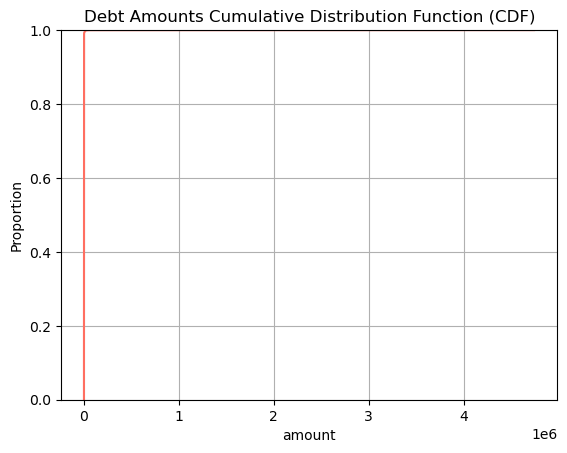

In [26]:
sns.ecdfplot(grouped_by_debt_id.amount, color='#FF6F61')
plt.title('Debt Amounts Cumulative Distribution Function (CDF)')
plt.grid()
plt.show()

This shows an extreme *right skweeness*. In fact, this is not supprising thing! If you think about it, the number of debts would get smaller and smaller as the value of it's amount get larger. Think about it like in salaries distribution. The number of people with salaries in range from 300-500 JOD would be the largest category in the society, like wise for those with salaries greater than 1,000 JOD or even 100,000 JOD!

Let's look at a more clearer plots:

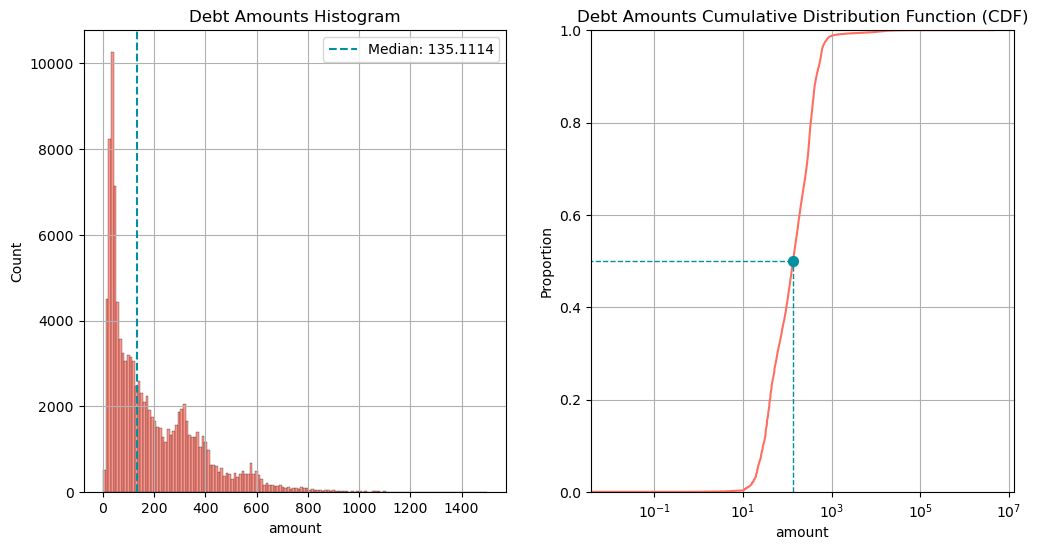

<Figure size 640x480 with 0 Axes>

In [27]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

trimmed_amount = grouped_by_debt_id.amount[grouped_by_debt_id.amount < 1500]
sns.histplot(trimmed_amount, color='#FF6F61', ax=axes[0])
axes[0].axvline(grouped_by_debt_id.amount.median(), color='#00909E', linestyle='--', label=f'Median: {grouped_by_debt_id.amount.median()}')
axes[0].legend()
axes[0].grid()
axes[0].set_title('Debt Amounts Histogram')

sns.ecdfplot(grouped_by_debt_id.amount, color='#FF6F61', ax=axes[1])
median_value = grouped_by_debt_id.amount.median()
axes[1].scatter([median_value], [0.5], color='#00909E', s=50, zorder=5, label='Median')
axes[1].plot([median_value, median_value], [0, 0.5], color='#00909E', linestyle='--', linewidth=1)
axes[1].plot([axes[1].get_xlim()[0], median_value], [0.5, 0.5], color='#00909E', linestyle='--', linewidth=1)
axes[1].set_xscale('log')
axes[1].grid()
axes[1].set_title('Debt Amounts Cumulative Distribution Function (CDF)')

plt.show()

plt.suptitle('Debt Amounts Distribution')
plt.tight_layout()
plt.show()

The histogram shows the debt `amount` distribution for those debts with amount less than 1500 JOD. However, as the value of `amount` on the x axis get larger, the bins would get smaller and smaller until it reach the maximum amount value, which is 4,750,000 JOD.

The right *cdf* plot is the same as the previous one with log scal for x axis instead of linear one.

Awesome!

### Amount Outstanding Analysis

Next, let's explore the distribution of `amount outstanding` column, which wont differ from the `amount` columns:

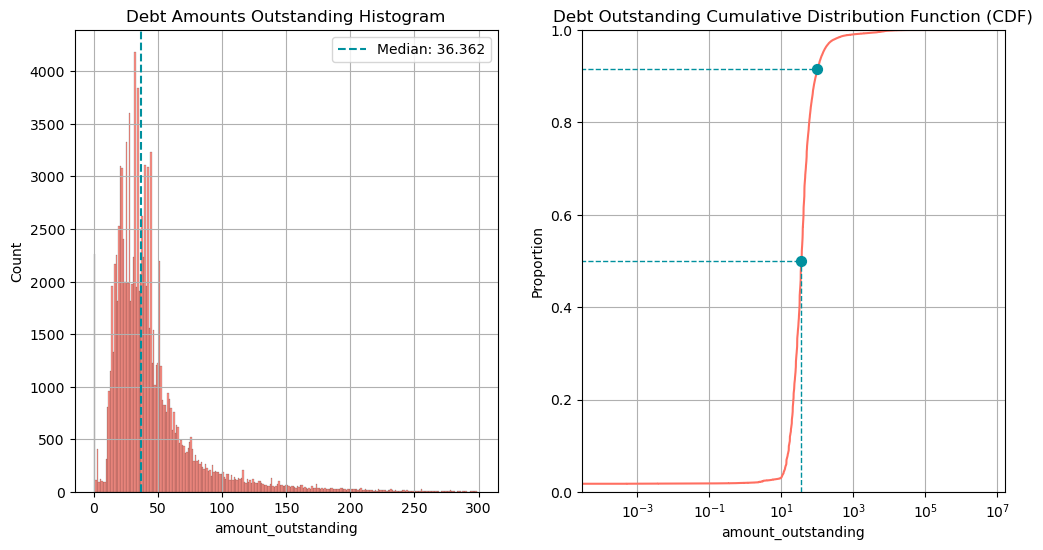

<Figure size 640x480 with 0 Axes>

In [28]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

trimmed_amount_outstanding = grouped_by_debt_id.amount_outstanding[grouped_by_debt_id.amount_outstanding < 300]
sns.histplot(trimmed_amount_outstanding, color='#FF6F61', ax=axes[0])
axes[0].axvline(grouped_by_debt_id.amount_outstanding.median(), color='#00909E', linestyle='--', label=f'Median: {grouped_by_debt_id.amount_outstanding.median()}')
axes[0].legend()
axes[0].grid()
axes[0].set_title('Debt Amounts Outstanding Histogram')

sns.ecdfplot(grouped_by_debt_id.amount_outstanding, color='#FF6F61', ax=axes[1])
median_value = grouped_by_debt_id.amount_outstanding.median()
axes[1].scatter([median_value], [0.5], color='#00909E', s=50, zorder=5, label='Median')
axes[1].plot([median_value, median_value], [0, 0.5], color='#00909E', linestyle='--', linewidth=1)
axes[1].plot([axes[1].get_xlim()[0], median_value], [0.5, 0.5], color='#00909E', linestyle='--', linewidth=1)
axes[1].plot([axes[1].get_xlim()[0], 100], [0.915, 0.915], color='#00909E', linestyle='--', linewidth=1)
axes[1].scatter([100], [0.915], color='#00909E', s=50, zorder=5, label='Median')
axes[1].set_xscale('log')
axes[1].grid()
axes[1].set_title('Debt Outstanding Cumulative Distribution Function (CDF)')

plt.show()

plt.suptitle('Debt Outstanding Distribution')
plt.tight_layout()

plt.show()

In [29]:
grouped_by_debt_id.amount_outstanding.quantile(0.915)

101.55520200000005

This histogram shows the distribution of `amount outstanding` that is less than 300 JOD, and again, as the value of `amount outstanding` increases, the number of debts that fall into the same bin will decrease until it reach the maximum `amount outstanding` value which was 4.75 M.

This histogram as the previous one shows a right skewness which need to be scaled before starting modeling to make it more normal.

The right *cdf* shows a sharp rise from 10 JOD to about 100 JOD. In fact, about 91% of debt `amount outstanding` values falls in that bucket!

### Transferred Amount Analysis

Well, let's take a closer look at the `total transferred amount` distribution now:

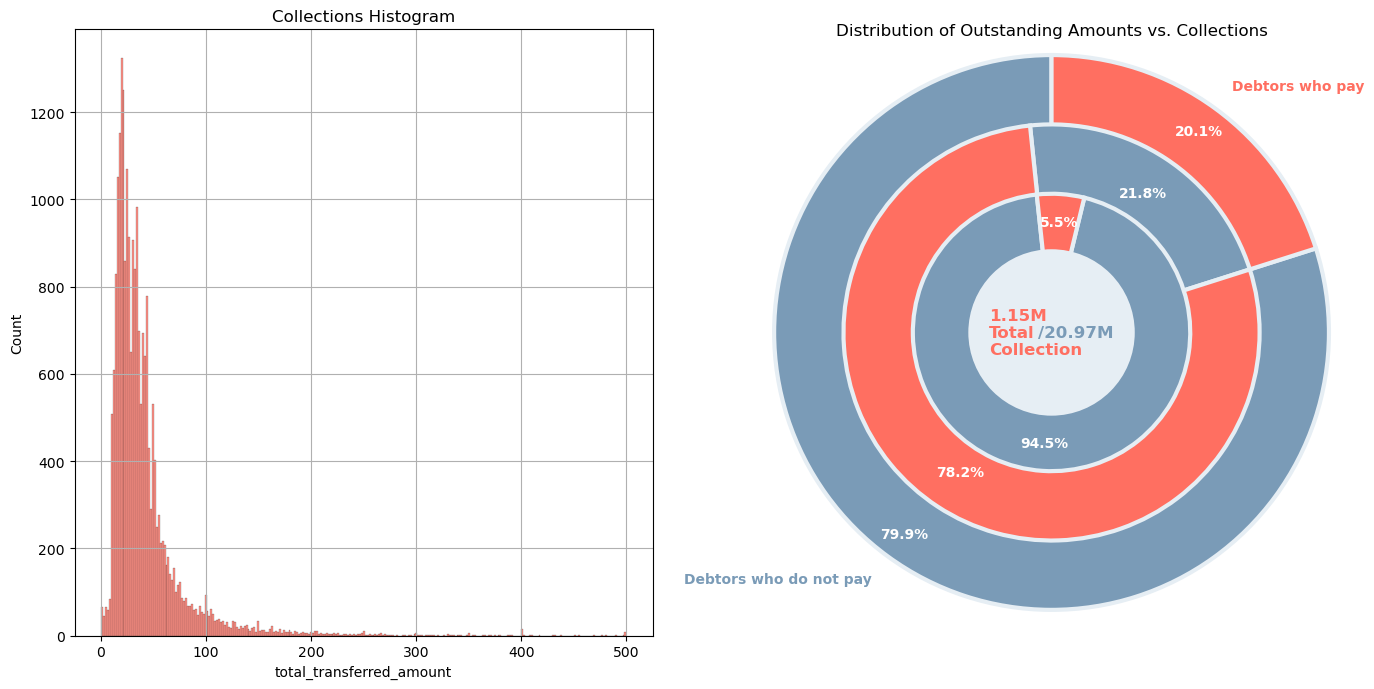

In [30]:
paid_grouped_by_debt_id = grouped_by_debt_id[grouped_by_debt_id.total_transferred_amount != 0]
trimmed_total_transferred_amount = paid_grouped_by_debt_id.total_transferred_amount[(paid_grouped_by_debt_id.total_transferred_amount <= 500)]
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 7))

paid_total_collection = paid_grouped_by_debt_id.total_transferred_amount.sum()
paid_total_amount_outstanding = paid_grouped_by_debt_id.amount_outstanding.sum()
total_collection = grouped_by_debt_id.total_transferred_amount.sum()
total_amount_outstanding = grouped_by_debt_id.amount_outstanding.sum()

inner_sizes1 = (paid_total_amount_outstanding - paid_total_collection) / paid_total_amount_outstanding, paid_total_collection / paid_total_amount_outstanding
inner_sizes = (total_amount_outstanding - total_collection) / total_amount_outstanding, total_collection / total_amount_outstanding

outer_sizes = [(grouped_by_debt_id.total_transferred_amount == 0).sum(), (grouped_by_debt_id.total_transferred_amount != 0).sum()]
outer_labels = ['Debtors who do not pay', 'Debtors who pay']

colors = ['#7A9BB7', '#FF6F61']

sns.histplot(trimmed_total_transferred_amount, color='#FF6F61', ax=axes[0])

startangle = 90
r = 1.2
wedges, texts, autotexts = axes[1].pie(outer_sizes, labels=outer_labels, colors=colors, 
                            autopct='%1.1f%%', startangle=startangle, radius=r,
                            wedgeprops={'edgecolor': '#E6EEF4', 'linewidth': 3},
                            textprops={'fontsize': 10, 'fontweight': 'bold', 'color': 'white'},
                            pctdistance=0.9)

for i, text in enumerate(texts):
    text.set_color(colors[i])

axes[1].pie(inner_sizes1, colors=colors, startangle=startangle - (0.201 * 360), 
            autopct='%1.1f%%', wedgeprops={'edgecolor': '#E6EEF4', 'linewidth': 3}, 
            radius=0.75 * r,
            textprops={'fontsize': 10, 'fontweight': 'bold', 'color': 'white'},
            pctdistance=0.8)

axes[1].pie(inner_sizes, colors=colors, startangle=startangle - ((0.201 + 0.782) * 360), 
            autopct='%1.1f%%', wedgeprops={'edgecolor': '#E6EEF4', 'linewidth': 3}, 
            radius=0.5 * r,
            textprops={'fontsize': 10, 'fontweight': 'bold', 'color': 'white'},
            pctdistance=0.8)


centre_circle = plt.Circle((0, 0), radius=0.3 * r, color='white', fc='#E6EEF4', linewidth=0)
axes[1].add_artist(centre_circle)

axes[1].text(-0.27, 0, f'{round(grouped_by_debt_id.total_transferred_amount.sum() / 1e6, 2)}M\nTotal\nCollection',
          fontsize=12, fontweight='bold', color='#FF6F61',
          ha='left', va='center')

axes[1].text(0.27, 0, f'/{round(grouped_by_debt_id.amount_outstanding.sum() / 1e6, 2)}M',
          fontsize=12, fontweight='bold', color='#7A9BB7',
          ha='right', va='center')


axes[1].set_title("Distribution of Outstanding Amounts vs. Collections")
axes[0].set_title('Collections Histogram')
axes[0].grid()
plt.tight_layout()
plt.show()

This histogram displays the total collections made by collectors on each debt. As we move to the right along the x-axis, the count decreases until it reaches the maximum `transferred amount` of 7,000 JOD.

Note that this histogram only includes debts with a `total transferred amount` greater than 0 (i.e., debts on which at least one transfer has been made). These debts represent 20.1% of the total 113,589 debts as shown on the right doughnut chart.

Diving one more layer into the doughnut chart, we can see the distribution of the `amount collected` from debts where the debtors made payments, corresponding to the histogram on the left. As shown, collectors were able to collect about 78.2% of the `total amount outstanding`, which is equivalent to approximately 1.47M JOD, from those debts which is worth about 1.15M JOD.

But don't be too optimistic, this only represents about 5.5% of the total `amount outstanding`, which is approximately 21M JOD.

### Debt Ages

Nice, let's see how the `debt ages` are distributed now:

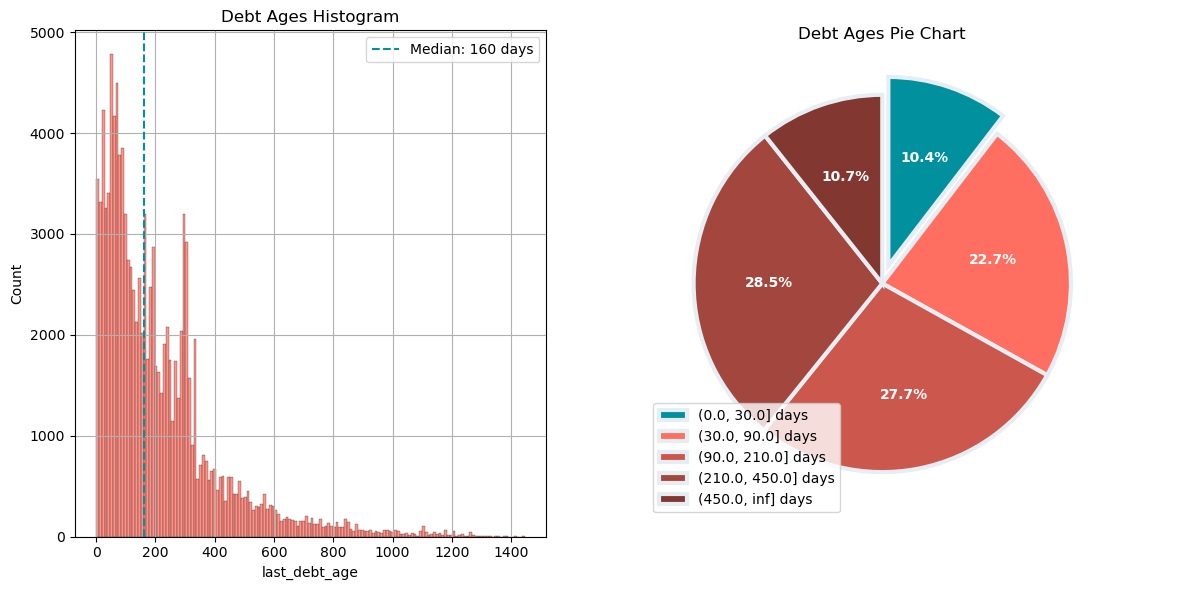

In [31]:
# some helper functions
def hex_to_rgb(hex_color):
    hex_color = hex_color.lstrip('#')
    return tuple(int(hex_color[i:i+2], 16) for i in (0, 2, 4))

def rgb_to_hex(rgb_color):
    return '#{:02x}{:02x}{:02x}'.format(*rgb_color)

def adjust_brightness(rgb_color, factor, darker):
    if darker:
        return tuple(max(0, int(c * factor)) for c in rgb_color)
    else:
        return tuple(min(255, int(c + (255 - c) * (1 - factor))) for c in rgb_color)

def generate_colors(hexcolor, c, size, darker=False):
    rgb_color = hex_to_rgb(hexcolor)
    
    colors = []
    
    for _ in range(size):
        colors.append(rgb_to_hex(rgb_color))
        rgb_color = adjust_brightness(rgb_color, 1 - c, darker)
    
    return colors



debt_ages = grouped_by_debt_id.last_debt_age.dt.days
colors = generate_colors('#FF6F61', 0.2, 4, True)
colors = ['#00909E'] + colors

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

sns.histplot(debt_ages, color='#FF6F61', ax=axes[0])
bins = pd.cut(debt_ages, np.append(np.array([0, 30, 60, 120, 240]).cumsum(), np.inf)).value_counts(normalize=True)
bins.sort_index(inplace=True)

axes[1].pie(bins, labels=bins.index, colors=colors, 
            startangle=startangle, counterclock=False, 
            explode=[0.1, 0, 0, 0, 0],
            autopct='%1.1f%%', 
            wedgeprops={'edgecolor': '#E6EEF4', 'linewidth': 3},
            textprops={'fontsize': 10, 'fontweight': 'bold', 'color': 'white'}
           )

pie_legend = axes[1].legend(loc='lower left')

for text in pie_legend.texts:
    text.set_text(text.get_text() + ' days')

axes[1].set_title('Debt Ages Pie Chart')

axes[0].axvline(debt_ages.median(), color='#00909E', linestyle='--', label=f'Median: {int(debt_ages.median())} days')
axes[0].legend()
axes[0].grid()
axes[0].set_title('Debt Ages Histogram')

plt.tight_layout()
plt.show()

This histogram shows the distribution of `debt ages`. As we can see, the `debt ages` are concentrated in the first 200 days of entry into the system and the ages were ranged from 0 ages to 1447 days, which is the largest `debt age` was registered.

The pie chart on the right categorizes the ages into intervals. One may think that, as the `debt age` get larger and larger, the chance of collect the `amount outstanding` becomes more smaller. We can verify this in [Bivariate Analysis](#Bivariate-Analysis) section.

### To Service End Date

Next, let's review the `to service end date` column:

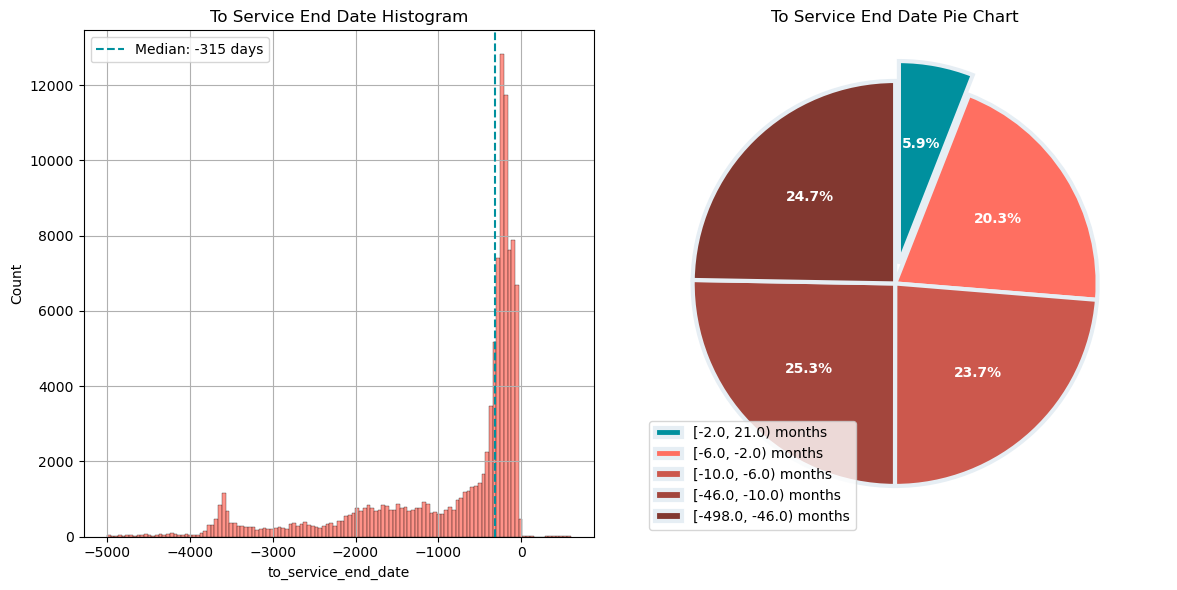

In [32]:
to_service_end_dates_in_days = grouped_by_debt_id.to_service_end_date.dt.days
trimmed_to_service_end_dates_in_days = to_service_end_dates_in_days[to_service_end_dates_in_days >= -5000]
to_service_end_dates_in_months = (grouped_by_debt_id.to_service_end_date.dt.days / 30).round()

colors = generate_colors('#FF6F61', 0.2, 4, True)
colors = ['#00909E'] + colors

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

sns.histplot(trimmed_to_service_end_dates_in_days, color='#FF6F61', ax=axes[0])

bins = pd.cut(to_service_end_dates_in_months, 
              [to_service_end_dates_in_months.min(), 
               to_service_end_dates_in_months.quantile(0.25), 
               to_service_end_dates_in_months.quantile(0.50), 
               to_service_end_dates_in_months.quantile(0.75),
               -2,
               to_service_end_dates_in_months.max() + 1], right=False).value_counts(normalize=True)
bins.sort_index(inplace=True, ascending=False)

axes[1].pie(bins, labels=bins.index, colors=colors, 
            startangle=startangle, counterclock=False, 
            explode=[0.1, 0, 0, 0, 0],
            autopct='%1.1f%%', 
            wedgeprops={'edgecolor': '#E6EEF4', 'linewidth': 3},
            textprops={'fontsize': 10, 'fontweight': 'bold', 'color': 'white'}
           )

pie_legend = axes[1].legend(loc='lower left')

for text in pie_legend.texts:
    text.set_text(text.get_text() + ' months')
    
axes[1].set_title('To Service End Date Pie Chart')

axes[0].axvline(to_service_end_dates_in_days.median(), color='#00909E', linestyle='--', label=f'Median: {int(to_service_end_dates_in_days.median())} days')
axes[0].legend()
axes[0].grid()
axes[0].set_title('To Service End Date Histogram')

plt.tight_layout()
plt.show()

This histogram shows the distribution for the `to service end date` column. It is a left-skewed distribution unlike the other distributions, which is normal! Agencies turn to collection companies to collect these difficult claims.

However, the minue sign here means that service has ended and the further to the left on the x-axis we go the count number on the y-axis gets smaller until we reach the lowest value for the `to service end date` column which was about 40 years (has a `service end date` of 1979-11-01), and the positive sign means that the `service end date` has not yet arrived.

The pie chart on the right divides the `to service end date` column into four categories using the 5-number summary and with one particular slice, colored cyan, represents approximately 5.9% of the debts. This slice highlights debts that either have just reached their `service end date` or have not yet passed it. These debts are considered easier to collect because they are still active or have only recently become due as we will see in the [Bivariate Analysis](#Bivariate-Analysis) section.

### Total Number of Contact

Last numerical column we have is the `total number of contact`, let's checl it's distribution:

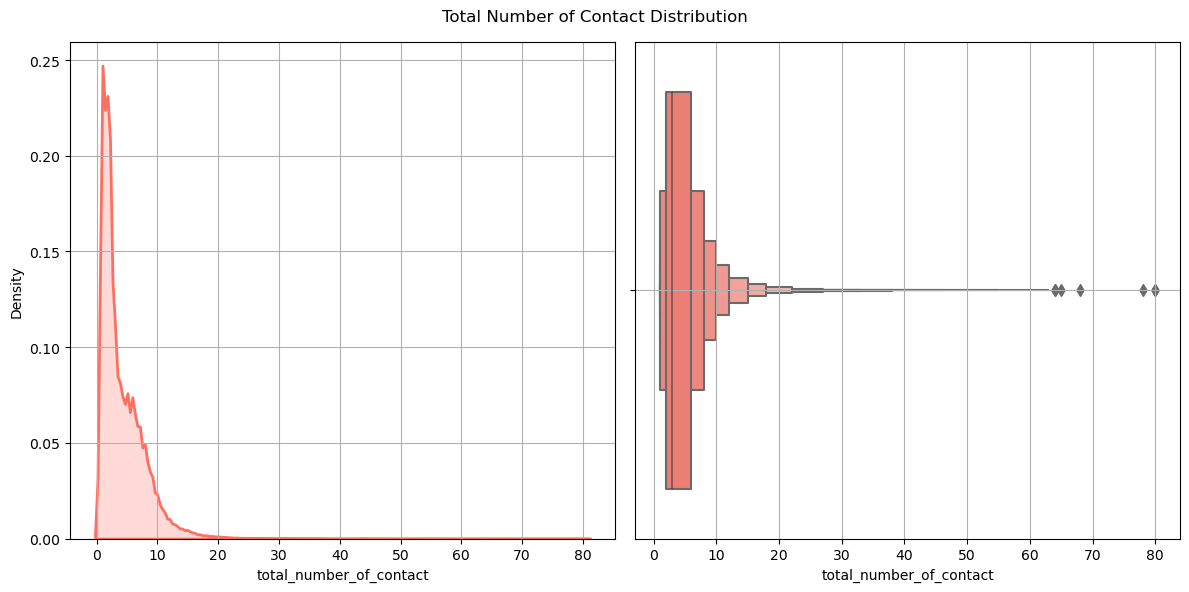

In [33]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

sns.kdeplot(grouped_by_debt_id.total_number_of_contact, fill=True, color='#FF6F61', bw_method=0.109, lw=2, ax=axes[0])
sns.boxenplot(x=grouped_by_debt_id.total_number_of_contact, color='#FF6F61', ax=axes[1])

axes[0].grid()
axes[1].grid()

plt.suptitle('Total Number of Contact Distribution')
plt.tight_layout()
plt.show()

The Kernel Density Plot (KDE plot) on the left represents the probability density function of the `total number of contacts` column. It smooths out the data distribution, providing a continuous estimate rather than a stepwise histogram.

From the KDE plot, we observe that approximately 25% of claims had only one contact attempt, and as the frequency of contacts decreasing as the `total number of contacts` increases.

The boxenplot on the right shows that the median number of contacts which was 3 contacts, with some claims being contacted over 60 times, and a maximum of 80 contacts.

## Categorical Columns Analysis

### Agent ID Analysis

Starting with `agents` we are dealing with:

In [34]:
grouped_by_debt_id.agent_id.value_counts()

agent_id
14      96574
3        9058
1        4831
1083     1592
2         621
10        321
46        240
2093      175
2086      123
49         12
1053       12
2095        5
2088        4
6           3
7           3
18          2
2091        1
2090        1
2096        1
2087        1
1054        1
2085        1
1057        1
1056        1
34          1
27          1
21          1
26          1
2099        1
Name: count, dtype: int64

We have 29 `agents` deealing with. Some of them has one claim and some others have a clamis in handreds. Well, let's create a new category for them, just to use it in the next viz no more, and give for them a special `agent id` of 0:

In [35]:
grouped_by_debt_id_copy = grouped_by_debt_id.copy()
grouped_by_debt_id_copy.loc[grouped_by_debt_id_copy.agent_id.isin(grouped_by_debt_id_copy.agent_id.value_counts()[grouped_by_debt_id_copy.agent_id.value_counts() < 500].index), 'agent_id'] = 0

A fast check:

In [36]:
grouped_by_debt_id_copy_agents_distribution = grouped_by_debt_id_copy.agent_id.value_counts()
grouped_by_debt_id_copy_agents_distribution

agent_id
14      96574
3        9058
1        4831
1083     1592
0         913
2         621
Name: count, dtype: int64

Great!

Next, let's create some vizes:

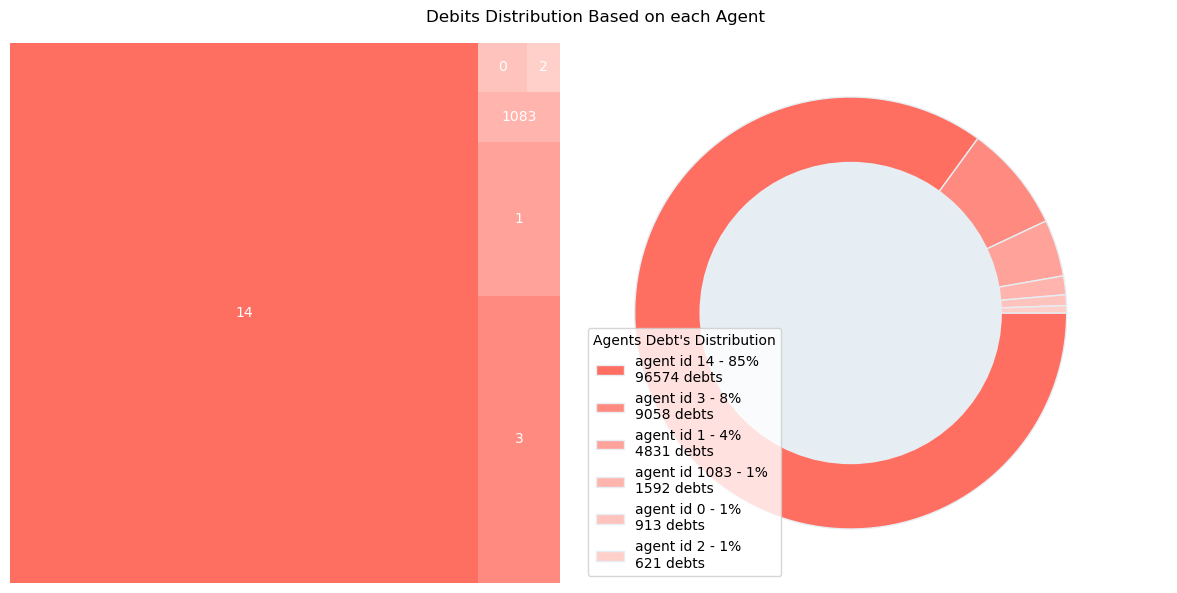

In [37]:
colors = generate_colors('#FF6F61', 0.2, grouped_by_debt_id_copy_agents_distribution.shape[0], False)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

squarify.plot(
    sizes=grouped_by_debt_id_copy_agents_distribution, 
    label=grouped_by_debt_id_copy_agents_distribution.index, 
    color=colors,
    text_kwargs={'color': 'white'},
    ax=axes[0]
)

axes[1].pie(grouped_by_debt_id_copy_agents_distribution, 
            labels=grouped_by_debt_id_copy_agents_distribution.index,
            colors=colors, counterclock=False,
            wedgeprops={'edgecolor': '#E6EEF4', 'linewidth': 1},
            textprops={'fontsize': 21, 'fontweight': 'bold', 'color': 'white'},
           )

pie_legend = axes[1].legend(loc='lower left', title='Agents Debt\'s Distribution')
for i, text in enumerate(pie_legend.texts):
    text.set_text(
        f'agent id {grouped_by_debt_id_copy_agents_distribution.iloc[[i]].index[0]} - {round(grouped_by_debt_id_copy_agents_distribution.iloc[i] / grouped_by_debt_id_copy_agents_distribution.sum() * 100)}% \n{grouped_by_debt_id_copy_agents_distribution.iloc[i]} debts'
    )
centre_circle = plt.Circle((0, 0), radius=0.7, color='white', fc='#E6EEF4', linewidth=0)
axes[1].add_artist(centre_circle)

axes[0].axis('off')
plt.suptitle('Debits Distribution Based on each Agent')

plt.tight_layout()
plt.show()

The treemap on the left illustrates how debts are distributed among `agents`. The largest portion, around 85%, is attributed to the agent with ID 14.

This pattern is consistent with the distribution of `amount outstanding`. It's not surprising—when a single agent handles a large number of debts, the median amount outstanding for those debts tends to be smaller compared to agents with fewer number of debts as we will see in the [Bivariate Analysis](#Bivariate-Analysis) section.

### Collector ID Analysis

Finally, let's check the distribution of the `collector id`:

In [38]:
grouped_by_debt_id.collector_id.value_counts()

collector_id
 16    26043
 19    23754
 30    15504
 21    15336
 14     9820
 20     6615
 45     6402
 18     4431
 10     3288
 28      834
 15      833
 17      339
 7       209
 27      108
 8        45
-1        15
 9         5
 25        4
 46        3
 2         1
Name: count, dtype: int64

Let's create a new category for those collectors which are assigned to smaller than 1000 debts, as we did before with `agent id` column, and give them a new collector id of 0:

In [39]:
grouped_by_debt_id_copy.loc[grouped_by_debt_id_copy.collector_id.isin(grouped_by_debt_id_copy.collector_id.value_counts()[grouped_by_debt_id_copy.collector_id.value_counts() < 1000].index), 'collector_id'] = 0
grouped_by_debt_id_copy_collectors_distribution = grouped_by_debt_id_copy.collector_id.value_counts()
grouped_by_debt_id_copy_collectors_distribution.sort_values(inplace=True)
grouped_by_debt_id_copy_collectors_distribution

collector_id
0      2396
10     3288
18     4431
45     6402
20     6615
14     9820
21    15336
30    15504
19    23754
16    26043
Name: count, dtype: int64

Awesome!

Let's create some vizes now:

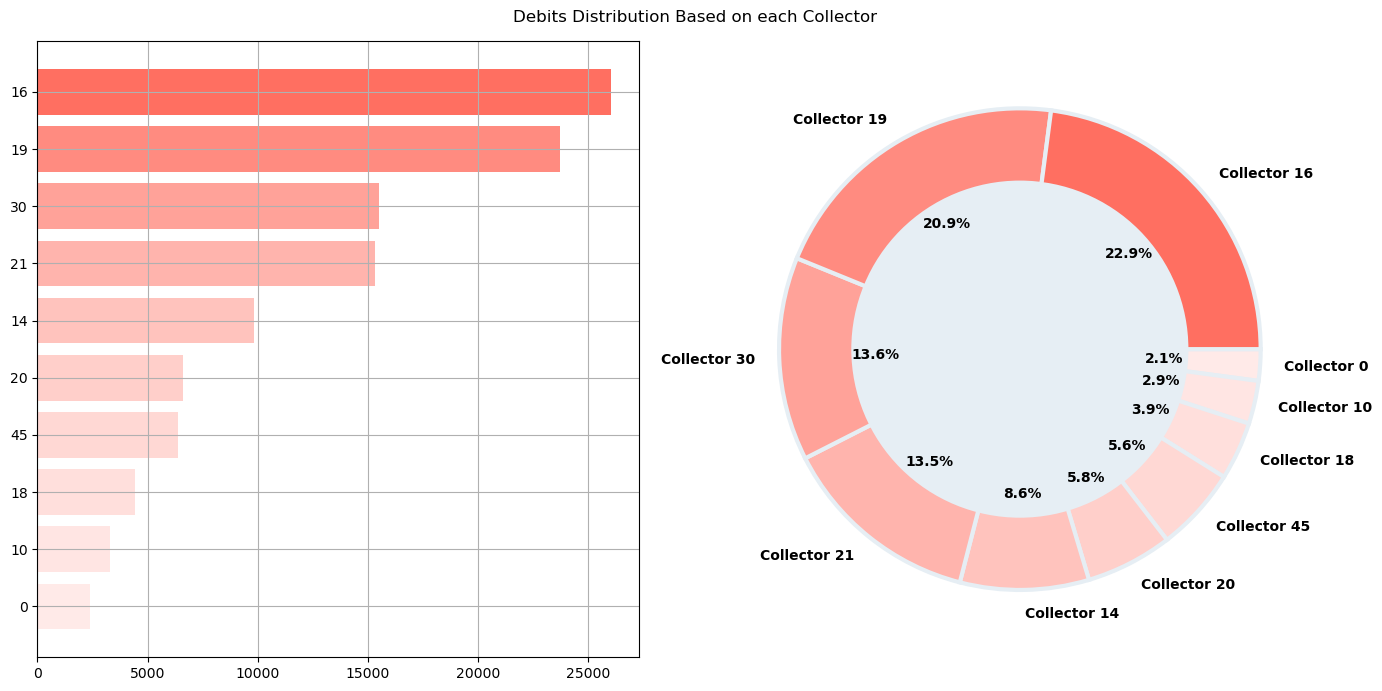

In [40]:
colors = generate_colors('#FF6F61', 0.2, grouped_by_debt_id_copy_collectors_distribution.shape[0], False)
colors.reverse()

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 7))

axes[0].barh(
    y=[str(label) for label in grouped_by_debt_id_copy_collectors_distribution.index],
    width=grouped_by_debt_id_copy_collectors_distribution,
    color=colors,
)
axes[0].grid()

axes[1].pie(grouped_by_debt_id_copy_collectors_distribution, 
            labels=[f'Collector {collector_id}' for collector_id in grouped_by_debt_id_copy_collectors_distribution.index],
            colors=colors, counterclock=False,
            wedgeprops={'edgecolor': '#E6EEF4', 'linewidth': 3},
            textprops={'fontsize': 10, 'fontweight': 'bold', 'color': 'black'},
            autopct='%1.1f%%', 
           )
    
centre_circle = plt.Circle((0, 0), radius=0.7, color='white', fc='#E6EEF4', linewidth=0)
axes[1].add_artist(centre_circle)

plt.suptitle('Debits Distribution Based on each Collector')
plt.tight_layout()
plt.show()

The job is distributed well among all the collector. However, the work ratios vary between them and this difference is most likely due to the history of their employment.

About a quarter of the claims are assigned to Collector 16 (equivalent to 26,043 claims), a fifth to Collector 19 (equivalent to 23,754 claims), and so on until we reach the collectors grouped in ID 0, who represent the lowest percentage of work.

# Bivariate Analysis

## Numerical-Numerical Relationships

In this phase we examine relationships between pairs of numerical variables. Are they correlated? Do they have a linear or non-linear relationship? This helps in understanding how variables interact and whether one might predict another.

But before we start, let's explain how to interpret the **Pearson Correlation Coefficient** which we will use it to assess the linear relationship between the numerical columns:

### Pearson Correlation Coefficient

**Strong Linear Relationship:**

- $|r| \geq 0.7$: A high absolute value indicates a strong linear relationship. For example, if $r = 0.8$ or $r = -0.8$, the relationship is considered strong.

**Moderate Linear Relationship:**

- $0.3 \leq |r| < 0.7$: A moderate absolute value suggests a moderate linear relationship. For instance, if $r = 0.5$ or $r = -0.5$, the relationship is moderate.

**Weak Linear Relationship:**

- $|r| < 0.3$: A low absolute value implies a weak linear relationship. For example, if $r = 0.2$ or $r = -0.2$, the relationship is weak.

Now, let's start by examine the linear correlation matrix:

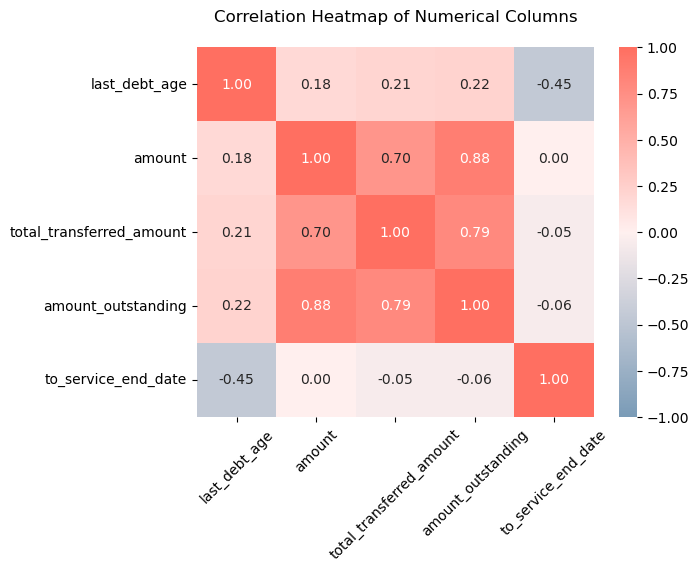

In [41]:
filtered_df = grouped_by_debt_id.loc[grouped_by_debt_id.total_transferred_amount != 0, num_atts]
for deltatime_col in filtered_df.select_dtypes('timedelta').columns:
    filtered_df[deltatime_col] = filtered_df[deltatime_col].dt.days.astype(float)

sns.heatmap(
    filtered_df.corr(), vmin=-1, vmax=1, 
    annot=True, fmt='.2f', 
    cmap=LinearSegmentedColormap.from_list("cmap", ['#7A9BB7', '#fff0ef','#FF6F61'])
)

plt.title('Correlation Heatmap of Numerical Columns\n', fontsize=12)
plt.xticks(rotation=45)
plt.show()

We have a nice look here!

From this matrix we can see that there are some very useful types of relationships that will facilitate the modeling process.

The `amout`, `total transferred amount`, and the `amount outstanding` are all *strongly positively* related to each other, meaning that as the value of one of them *increases*, the other values also *increase* accordingly.

In addition, the `debt age` column is *weakly positively* correlated with all other numeric columns except for the `to service end date`, which has a *moderate negative* correlation with this column. If you think about it, then you will find this is normal since the older the debt (`debt age` get larger), which is calculated based on the `contact date`, the further away we are from the `service end date` which used in order to calculate the values of the `to service end date`. 

Finally, the `to service end date` column, which does not bear any linear relationship with the other numerical columns except for the `debt age` column, which we have already explained in the previous paragraph.

The next *scatter plot* illustrates these coefficients and shows how each column value changes with respect to another column value and the main diagonal shows the *cdf* of each distribution:

/home/amq/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


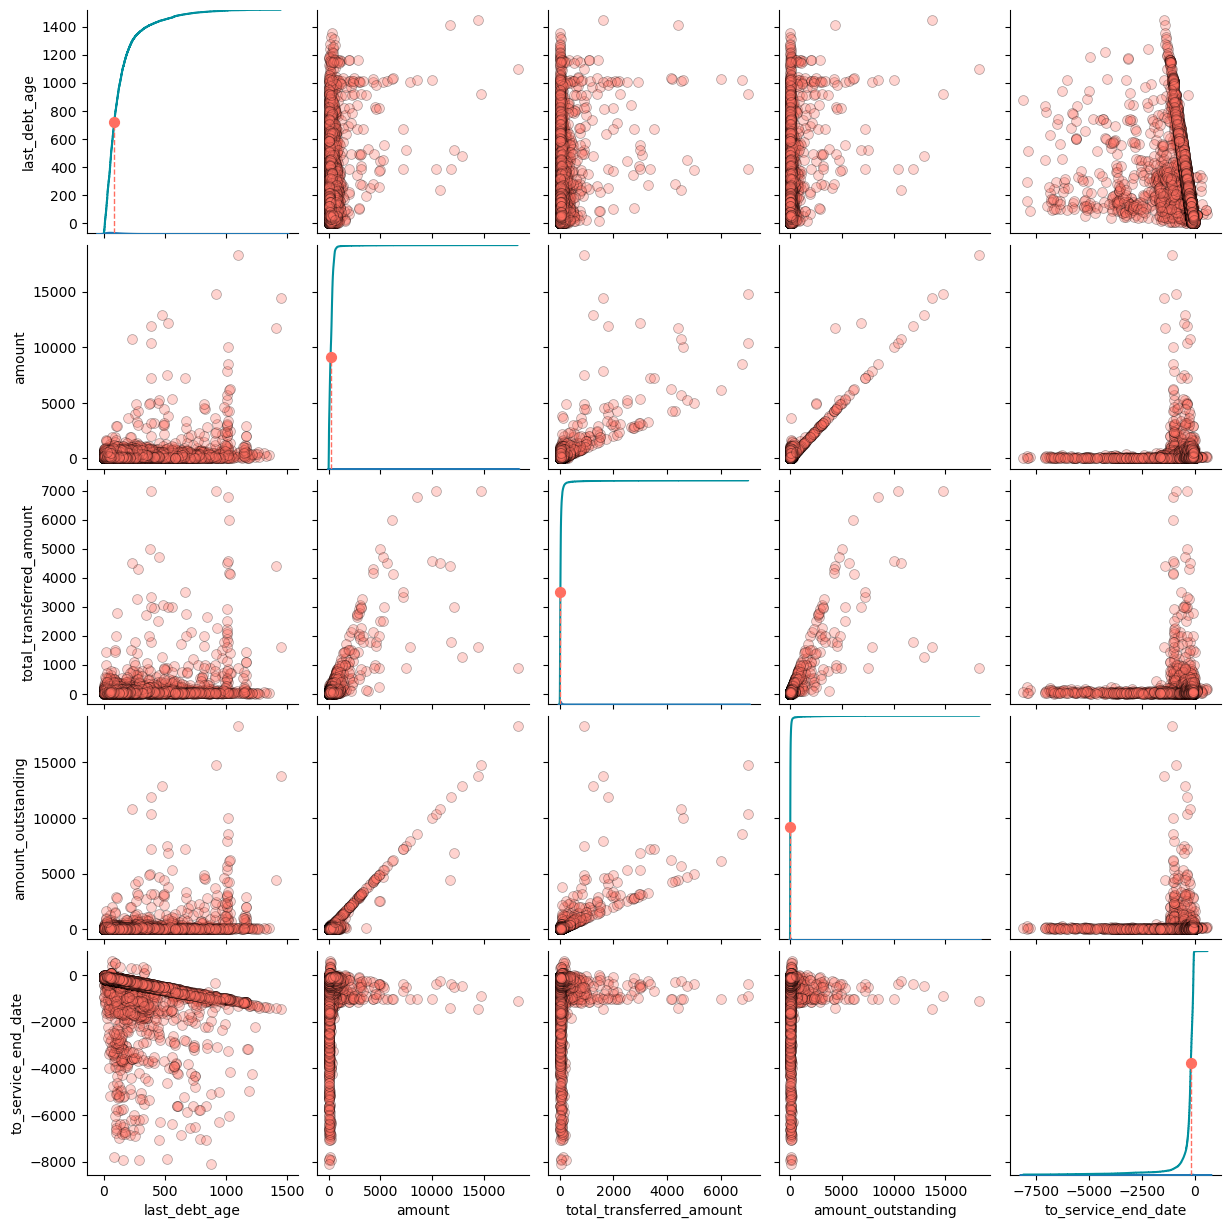

In [42]:
def plot_cdf(x, **kwargs):
    sns.ecdfplot(x, color='#00909E')
    median_value = x.median()
    plt.scatter([median_value], [0.5], color='#FF6F61', s=50, zorder=5, label='Median')
    plt.plot([median_value, median_value], [0, 0.5], color='#FF6F61', linestyle='--', linewidth=1)
    #plt.xscale('log')
    plt.grid()


g = sns.pairplot(filtered_df, diag_kind='kde', plot_kws={'alpha': 0.3, 's': 50, 'edgecolor': 'black', 'color': '#FF6F61'})
g.map_diag(plot_cdf)
plt.show()

Understanding the distribution of numerical columns is crucial for data analysis, as it can impact the performance of machine learning models and the relations between the columns. 

From the [Numerical Columns Analysis](#Numerical-Columns-Analysis), we observed that these numerical columns exhibit extreme right skewness, indicating they may follow a different distribution.

Well, let's check if these columns (the right skewed) follwos a *log-noraml* distribution:

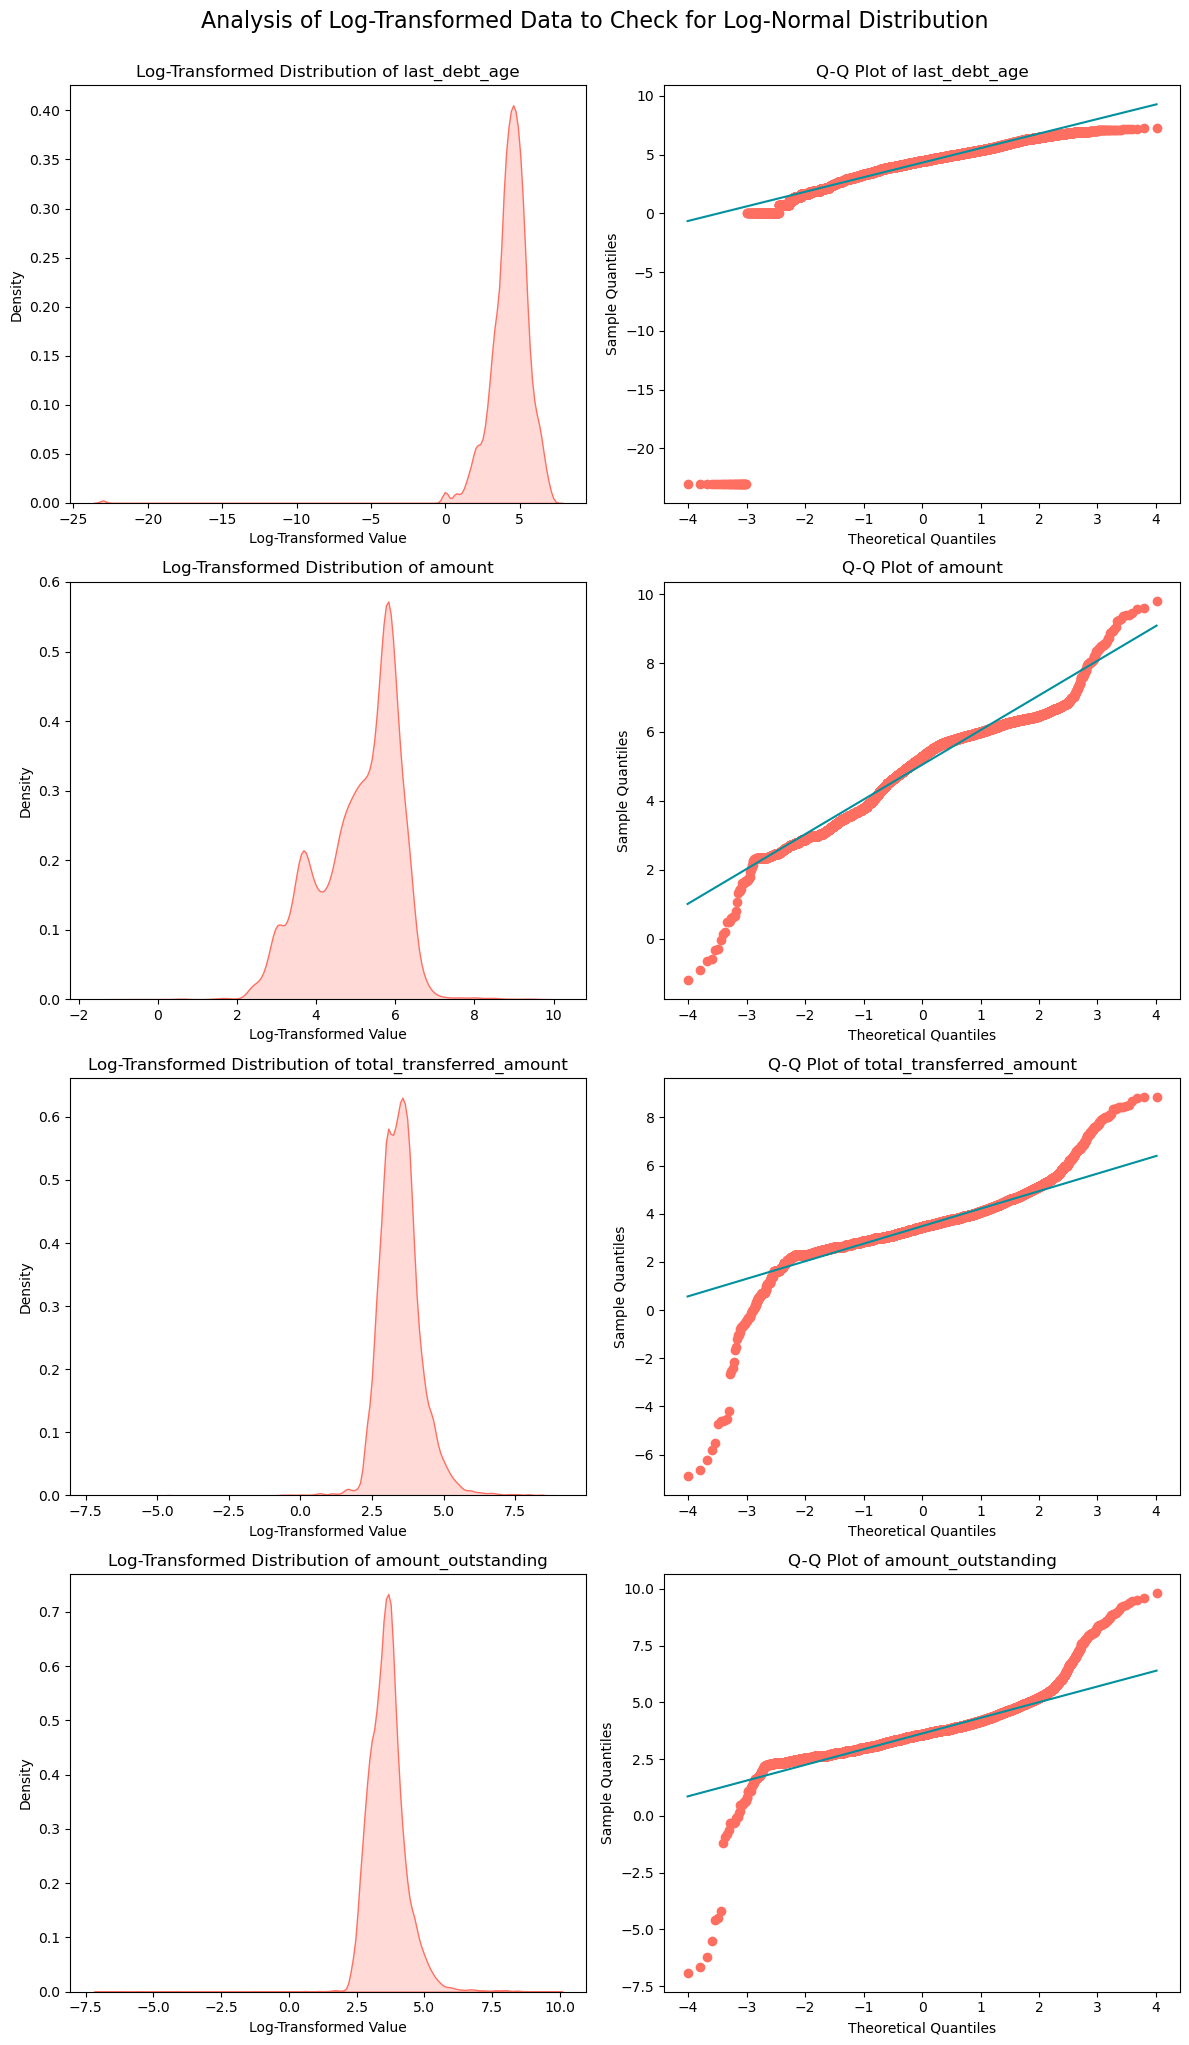

In [43]:
filtered_df_copy = filtered_df

epsilon = 1e-10

fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(12, 20))
right_skewed_cols = num_atts[:-1]
colors = ['#FF6F61', '#00909E']

for ax, col in zip(axes, right_skewed_cols):
    log_transed_col = np.log(filtered_df_copy[col] + epsilon)
    filtered_df_copy[col] = log_transed_col
    
    sns.kdeplot(log_transed_col, ax=ax[0], fill=True, color=colors[0])
    ax[0].set_title(f'Log-Transformed Distribution of {col}')
    ax[0].set_xlabel('Log-Transformed Value')
    ax[0].set_ylabel('Density')
    
    res = stats.probplot(log_transed_col, dist="norm")
    x = [res[0][0].min(), res[0][0].max()]
    y = [x[0] * res[1][0] + res[1][1], x[1] * res[1][0] + res[1][1]]
    
    ax[1].scatter(res[0][0], res[0][1], color=colors[0])
    ax[1].plot(x, y, color=colors[1])
    ax[1].set_title(f'Q-Q Plot of {col}')
    ax[1].set_xlabel('Theoretical Quantiles')
    ax[1].set_ylabel('Sample Quantiles')
    
plt.tight_layout()
plt.suptitle('Analysis of Log-Transformed Data to Check for Log-Normal Distribution', fontsize=16, y=1.02)
plt.show()

Actually, that seems good little bit!

Even more they do not actually follows a normal distribution, but this is better than the previous state.

But wait, dose we get the right relation coefficients for `debt ages` and `to service end dates` ? The answer is no.

Before we calculate the correlation coefficients we should group them first:

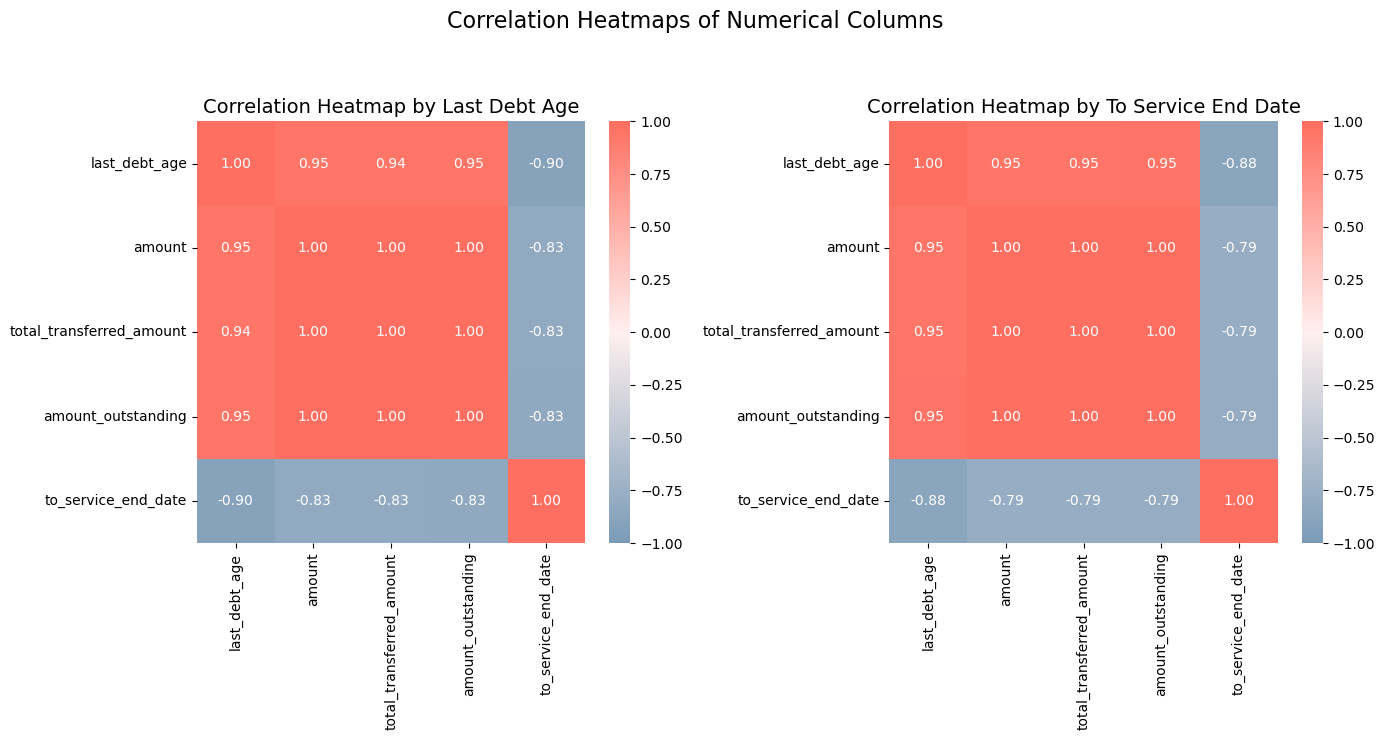

In [44]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 7))

cmap = LinearSegmentedColormap.from_list("cmap", ['#7A9BB7', '#fff0ef', '#FF6F61'])

sns.heatmap(
    filtered_df.groupby('last_debt_age')[num_atts].sum().corr(), vmin=-1, vmax=1, 
    annot=True, fmt='.2f', 
    cmap=cmap,
    ax=axes[0]
)

sns.heatmap(
    filtered_df.groupby('to_service_end_date')[num_atts].sum().corr(), vmin=-1, vmax=1, 
    annot=True, fmt='.2f', 
    cmap=cmap,
    ax=axes[1]
)
axes[0].set_title('Correlation Heatmap by Last Debt Age', fontsize=14)
axes[1].set_title('Correlation Heatmap by To Service End Date', fontsize=14)

plt.suptitle('Correlation Heatmaps of Numerical Columns', fontsize=16, y=1.05)
plt.tight_layout()
plt.show()

From this matrix we can see the exact correlations of both, `to service end date` and `debt age` columns with other columns.

The `debt age` column is strongly positively correlated with other columns except the `to service end date` column, which is strongly negatively correlated with it. While the `to service end date` is strongly negatively correlated with all columns meaning that as the `to service end date` increase other columns values get decrease.

## Categorical-Numerical Relationships

In this phase  we explore how categorical variables affect numerical ones. For example, do different categories have different means or variances? This can reveal important patterns.

Well, let's start exploring the collectors performance. Starting by preparing the data for the best five collectors with highest `collection amount`:

In [45]:
grouped_by_collector_id = grouped_by_debt_id.groupby('collector_id')[['total_number_of_contact', 'last_debt_age', 'debt_id', 'total_transferred_amount', 'amount_outstanding', 'to_service_end_date']].agg({
    'total_number_of_contact': 'sum',
    'last_debt_age': 'mean',
    'debt_id': 'size',
    'total_transferred_amount': 'sum',
    'amount_outstanding': 'sum',
    'to_service_end_date': 'mean'
})

for timedelta_col in grouped_by_collector_id.select_dtypes('timedelta').columns:
    grouped_by_collector_id[timedelta_col] = grouped_by_collector_id[timedelta_col].dt.days.astype(int)
    
grouped_by_collector_id.columns = ['total_number_of_contact', 'mean_debt_age', 'total_number_of_debts_works_on', 'total_collection', 'total_amount_outstanding', 'mean_to_service_end_date']
grouped_by_collector_id.sort_values(by=['total_collection'], ascending=False, inplace=True)
grouped_by_collector_id['mean_to_service_end_date'] = grouped_by_collector_id['mean_to_service_end_date'].abs()

best_5_collector = grouped_by_collector_id[:5].copy()

for col in best_5_collector:
    scaler = MinMaxScaler()
    best_5_collector.loc[:, col] = scaler.fit_transform(best_5_collector[col].to_numpy().reshape(-1, 1))

Next, creating some vizes showing how each collector from those performs with respect to other factors:

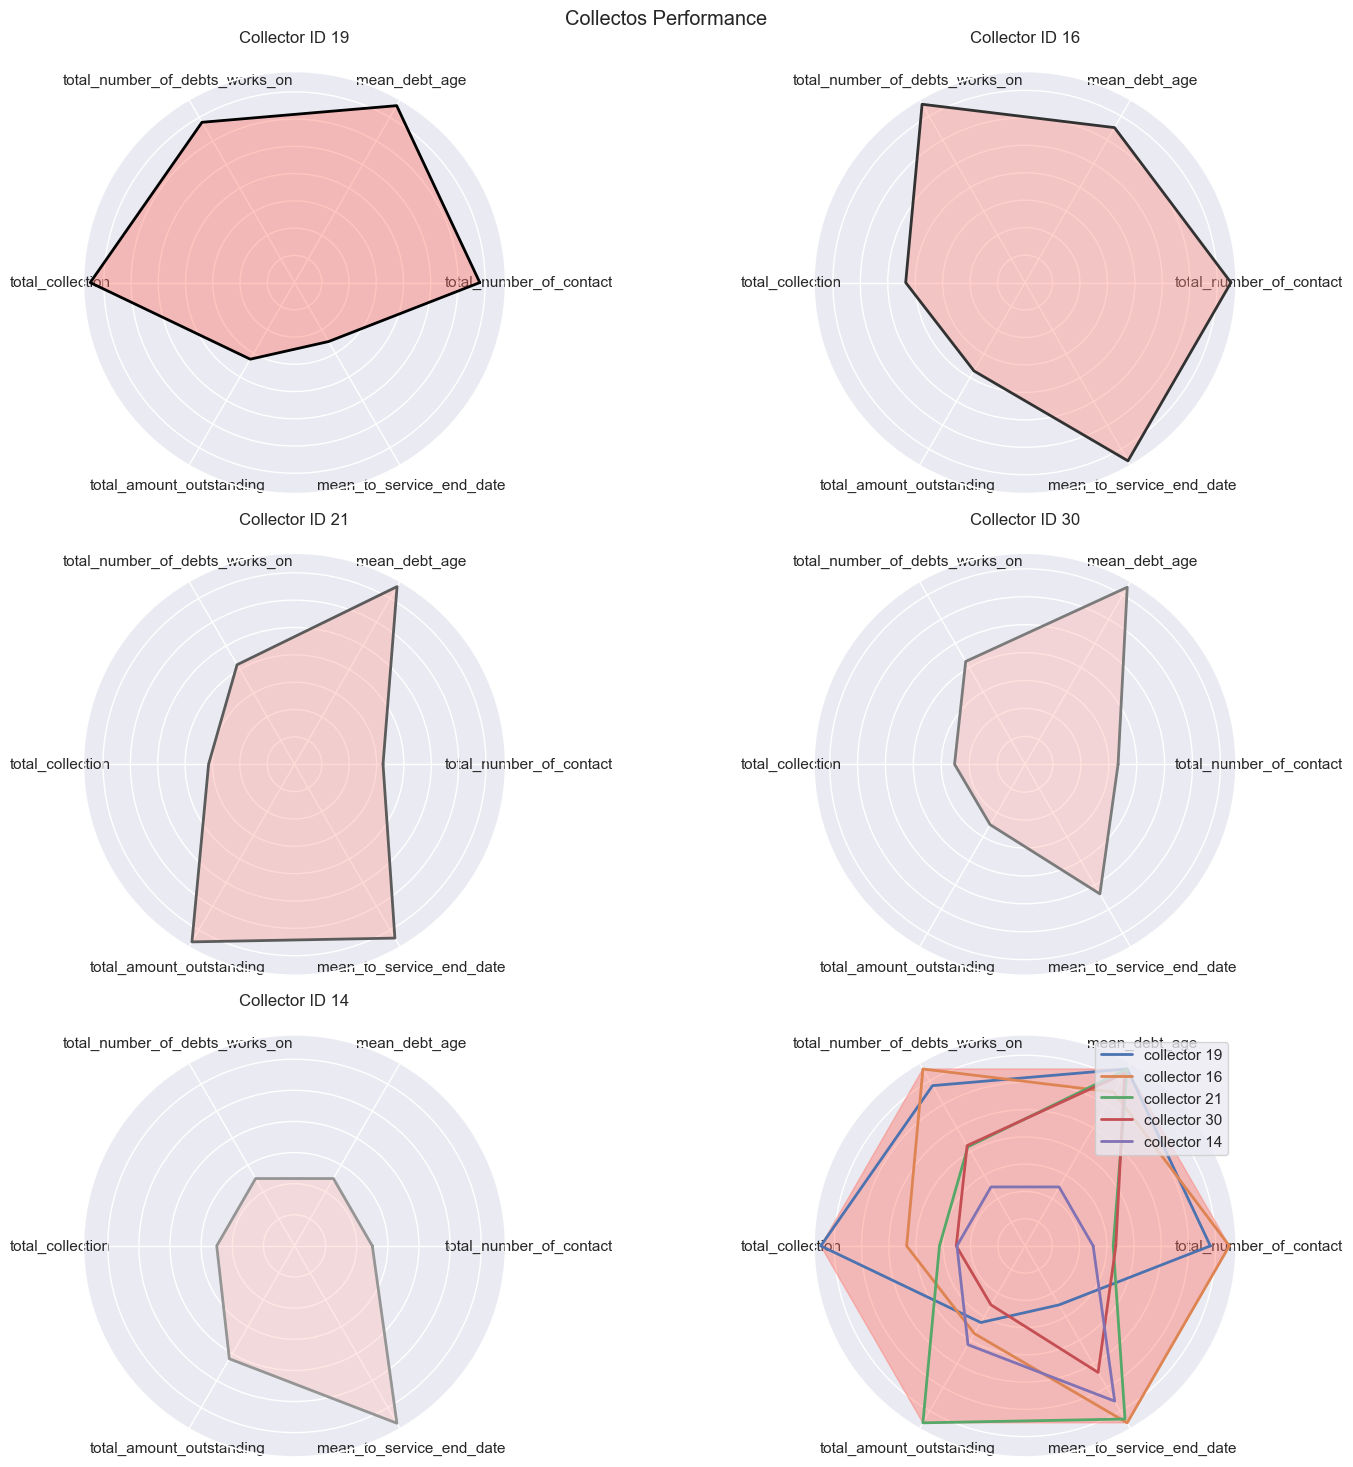

In [46]:
sns.set_theme(style="darkgrid")

fig, axes = plt.subplots(nrows=3, ncols=2, subplot_kw={'polar': True}, figsize=(15, 15))
axes = axes.flatten()

fill_colors = generate_colors('#FF6F61', 0.2, 5)
line_colors = generate_colors('#000000', 0.2, 5)
labels = best_5_collector.columns
num_vars = len(labels)

angles = [n / float(num_vars) * 2 * np.pi for n in range(num_vars)]
angles += angles[:1]

for color_idx, (ax, collector_id) in enumerate(zip(axes[:5], best_5_collector.index[:5])):
    values = list((best_5_collector.loc[collector_id] + 0.5))
    values += values[:1]
    
    ax.plot(angles, values, linewidth=2, linestyle='solid', label=f'collector {collector_id}', color=line_colors[color_idx])
    ax.fill(angles, values, color=fill_colors[color_idx], alpha=0.4)
    ax.set_title(f'Collector ID {collector_id}', y=1.05)
    ax.set_xticks(angles[:-1], labels)
    ax.set_yticklabels([])
    axes[5].plot(angles, values, linewidth=2, linestyle='solid', label=f'collector {collector_id}')
    
axes[5].legend(loc='upper right')
axes[5].set_xticks(angles[:-1], labels)
axes[5].fill(angles, np.ones(7) + 0.5, color='#FF6F61', alpha=0.4)
axes[5].set_yticklabels([])

plt.suptitle('Collectos Performance')
plt.tight_layout()
plt.show()

This Radar plot assess the top 5 collectors based on their work side, represented by their total `number of contact` and total `number of debts works on`, and based on the nature of debts they are working on, represented with other columns.

From this chart we can see how each columns are interacting affecting each other. As example, we can see a balance between total `amount collection` for collector with ID 21, who has the largest mean `to service end date` and total `cmount outstanding`.

As shown, the collector with ID 19 has the highest `collection amount`, `debt ages` average and lowest `to service end date` average which interpret the rise in `collection amount` even more the total debts `amout outstanding` he works on not lerge as with other collectors who have larger total `amout outstanding` and smaller `collection amount` like with collectors with ID 16 and 21, which indicates how much it is esier to work with like these debts.

Collector numbered 16 has both, largest total `number of contacts` and total `number of debts works on` showing a hard work by this collector, but he works with hard debts with a high `to service end date` average, actually he has the highest `to service end date` average which emphasize the hard work done by this collector again.

The collector numbered 21 works well with a very high `to service end date` average, making his job more challenging, but he work with the higest total `amount outstanding`, and a high `debt ages` which makes the challenge little easier.

Finally, the last collector, from those best 5 collector, with ID 14 who has the lowest `collection amount`, total `number of contact`, mean `debt age`, total `number of debts works on`, and a high `to service end date` average.

Again, this Rader assess the best 5 collectors, to see the full picture of collection rate for each collector consider the following charts: 

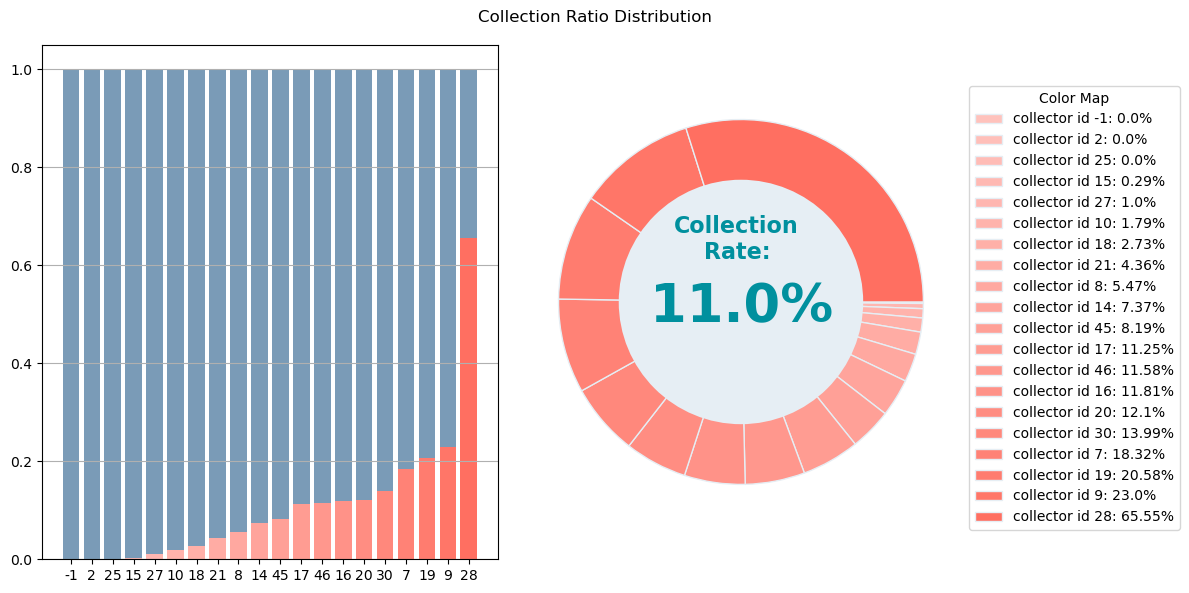

In [47]:
plt.rcdefaults()

collection_ratio = grouped_by_collector_id[['total_collection', 'total_amount_outstanding']].copy()
collection_ratio.loc[:, 'ratio'] = collection_ratio['total_collection'] / collection_ratio['total_amount_outstanding']
collection_ratio.sort_values(by='ratio', inplace=True)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
colors = list(reversed(generate_colors('#FF6F61', 1/20, 20)))

axes[0].bar(range(20), collection_ratio['ratio'], color=colors)
axes[0].bar(range(20), 1 - collection_ratio['ratio'], color='#7A9BB7', bottom=collection_ratio['ratio'])

axes[1].pie(
    collection_ratio['ratio'], 
    labels=collection_ratio.index,
    colors=colors, counterclock=False,
    wedgeprops={'edgecolor': '#E6EEF4', 'linewidth': 1},
    textprops={'color': 'white'},
)

pie_legend = axes[1].legend(loc=(1, 0), title='Color Map')
for i, text in enumerate(pie_legend.texts):
    text.set_text(
        f'collector id {collection_ratio.iloc[[i]].index[0]}: {round(collection_ratio.iloc[i, 2] * 100, 2)}%'
    )
    
centre_circle = plt.Circle((0, 0), radius=0.67 , color='white', fc='#E6EEF4', linewidth=0)
axes[1].add_artist(centre_circle)

axes[1].text(-0.37, 0.27, 'Collection\n    Rate:\n',
          fontsize=16, fontweight='bold', color='#00909E',
          ha='left', va='center')

axes[1].text(-0.5, -0.03, f'{round(collection_ratio.ratio.mean(), 2) * 100}%',
          fontsize=38, fontweight='bold', color='#00909E',
          ha='left', va='center')


axes[0].set_xticks(range(20), labels=collection_ratio.index)
axes[0].grid(True, axis='y')
plt.suptitle('Collection Ratio Distribution')
plt.tight_layout()
plt.show()

From this chart we can see how the total collected ration, 5.5%, are distributed across all collectors.

Well, the overall average collector performance (collection rate) was about 11%. Some of collectors have a 0.0% collection ratio, which may indicates there are some errors in their records and one collector, collector with ID 28,  has a collection ratio more than 60% from thier debts `amount standing` assigned for him which may indicates he is assign a small number of debts.

The collector with ID 19 relatively has a good collection ratio, he collect about 20% of `amount outstanding` assigned for him, which support the analysis from the rader chart we explain it previously. The same happens with collectors numbered 16 and 30.

The bar of collector numbered 21 shows that this collector under-performs as we seen from the rader chart for the same reasons we talk about actually, collectors 30 and 14 shows better performance than collector numbered 21 which indicates that collector numbered 21 worked on debts easy to collect and have a large `amout outstanding` as shown from the rader chart. While the collectors numbered 30 actually puts hard work to achieve this ratio since he assigned to debts with smaller `amount outstanding`.

In [48]:
grouped_by_debt_id_agent_id = grouped_by_debt_id.groupby('agent_id')[['debt_id', 'collector_id', 'total_transferred_amount', 'amount_outstanding', 'to_service_end_date', 'last_debt_age']].agg(
{
    'total_transferred_amount': 'sum',
    'amount_outstanding': 'sum',
    'to_service_end_date': 'mean',
    'last_debt_age': 'mean',
    'debt_id': 'size'
})

grouped_by_debt_id_agent_id.columns = [
    'total_transferred_amount', 'total_amount_outstanding', 'to_service_end_date_average', 
    'last_debt_age_average', 'total_number_of_debts'
    ]

grouped_by_debt_id_agent_id

,total_transferred_amount,total_amount_outstanding,to_service_end_date_average,last_debt_age_average,total_number_of_debts
agent_id,,,,,
1,24475.2140,6.149824e+05,-4042 days +22:47:51.951976832,180 days 03:48:01.639412130,4831
2,11500.0000,6.589205e+06,-255 days +11:37:58.260869564,163 days 06:41:09.565217392,621
3,139611.6207,7.396878e+05,-455 days +09:07:02.079929344,176 days 03:14:35.160079488,9058
6,0.0000,1.556499e+05,-247 days +08:00:00,246 days 16:00:00,3
7,0.0000,1.345597e+05,-305 days +16:00:00,304 days 08:00:00,3
10,151116.1270,1.094745e+06,-391 days +14:39:15.140186916,390 days 09:20:44.859813084,321
14,708614.1718,3.996759e+06,-879 days +13:10:57.642843840,217 days 19:50:50.386232316,96574
18,0.0000,2.156810e+05,-4185 days +12:00:00,414 days 00:00:00,2
21,0.0000,3.084000e+05,-560 days +00:00:00,560 days 00:00:00,1


Let's filter out the agents with 0 JOD `collection amount` and give those agencies with `total number of debts` less than 1000 debts a new `agent id` of 0:

In [49]:
grouped_by_debt_id_agent_id = grouped_by_debt_id_agent_id[grouped_by_debt_id_agent_id.total_transferred_amount > 0]
agents_with_less_1000_claims = grouped_by_debt_id_agent_id[grouped_by_debt_id_agent_id.total_number_of_debts < 1000]
grouped_by_debt_id_agent_id.loc[0, :] = np.array([
    agents_with_less_1000_claims['total_transferred_amount'].sum(),
    agents_with_less_1000_claims['total_amount_outstanding'].sum(),
    agents_with_less_1000_claims['to_service_end_date_average'].mean(),
    agents_with_less_1000_claims['last_debt_age_average'].mean(),
    agents_with_less_1000_claims['total_number_of_debts'].sum()
    ])

grouped_by_debt_id_agent_id.drop(agents_with_less_1000_claims.index, inplace=True)

for timedelta_col in grouped_by_debt_id_agent_id.select_dtypes('timedelta').columns:
    grouped_by_debt_id_agent_id[timedelta_col] = grouped_by_debt_id_agent_id[timedelta_col].dt.days.astype(int)
    
grouped_by_debt_id_agent_id

/tmp/ipykernel_132666/1164826909.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  grouped_by_debt_id_agent_id.loc[0, :] = np.array([


,total_transferred_amount,total_amount_outstanding,to_service_end_date_average,last_debt_age_average,total_number_of_debts
agent_id,,,,,
1,24475.2140,6.149824e+05,-4042,180,4831.0
3,139611.6207,7.396878e+05,-455,176,9058.0
14,708614.1718,3.996759e+06,-879,217,96574.0
1083,49633.7480,2.755954e+05,-158,165,1592.0
0,229650.3393,8.109555e+06,-541,435,1493.0


They are look better now.

Next, let's visualize them:

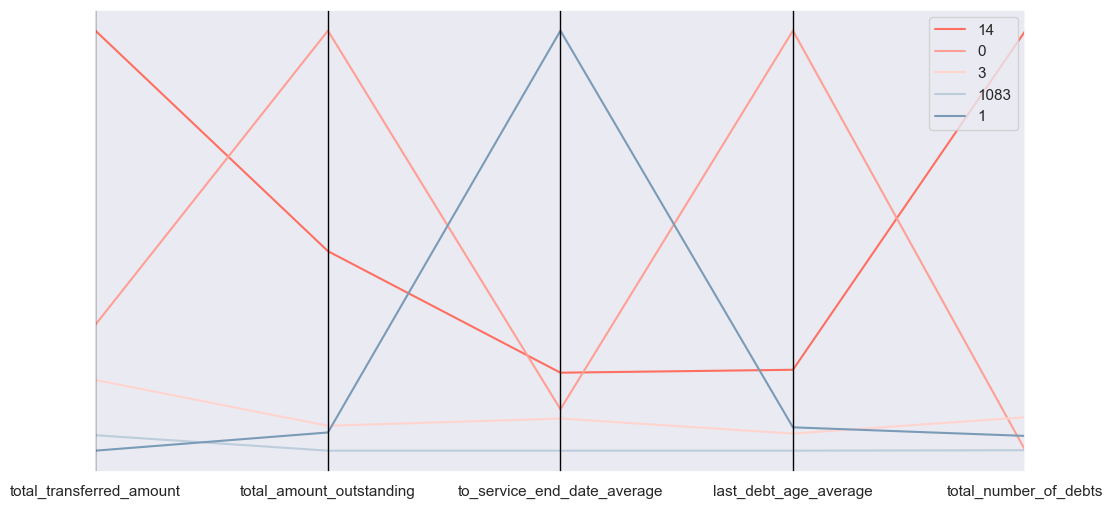

In [50]:
grouped_by_debt_id_agent_id['to_service_end_date_average'] = grouped_by_debt_id_agent_id['to_service_end_date_average'].abs()

grouped_by_debt_id_agent_id_collection_ratio = grouped_by_debt_id_agent_id[['total_transferred_amount', 'total_amount_outstanding']].copy()
grouped_by_debt_id_agent_id_collection_ratio['collection_ratio'] = grouped_by_debt_id_agent_id_collection_ratio['total_transferred_amount'] / grouped_by_debt_id_agent_id_collection_ratio['total_amount_outstanding']

for col in grouped_by_debt_id_agent_id.columns:
    grouped_by_debt_id_agent_id[col] = scaler.fit_transform(np.reshape(grouped_by_debt_id_agent_id[col], (-1, 1)))

grouped_by_debt_id_agent_id.reset_index(inplace=True)
grouped_by_debt_id_agent_id.sort_values(by=['total_transferred_amount'], ascending=False, inplace=True)

sns.set_theme(style="darkgrid")

plt.figure(figsize=(12, 6))
axes =  plt.subplot(111)

parallel_coordinates(grouped_by_debt_id_agent_id, 'agent_id', ax=axes, color=['#ff6f61', '#ff9f95', '#ffd4cf', '#bccddb', '#7a9bb7'])
plt.yticks([])

plt.show()

From this chart we can assess the quality of claims for each agent. Starting with agent with ID 14 which has the highest `total transerred mount`. This not suppressing since it has the largest `number of debts` and relatively high `total amount outstanding`.

The next performing well `agent id` we have is these agents we summed up together. They have the second highest `collection amount` due to reasons of they have the highest `total amount outstanding` and highest `debt ages` average.

Finally, the agent with ID 1 has the smallest `total collection amount` since it has the highest `to service end date` and small `number of debts`, `total amount outstanding`, and `debt ages` average.

Finally, let's compute the agents collection rate:

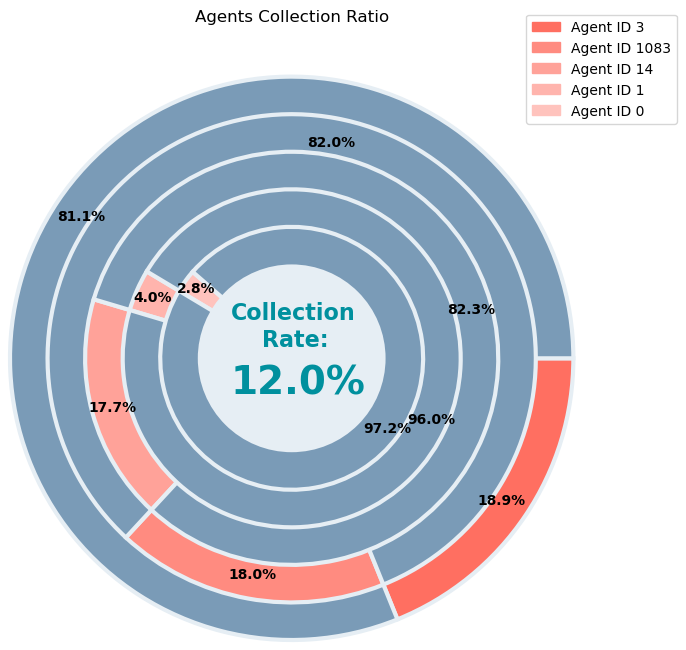

In [51]:
sorted_ratios = grouped_by_debt_id_agent_id_collection_ratio['collection_ratio'].sort_values(ascending=False)

plt.rcdefaults()
plt.figure(figsize=(7, 7))

start_angle = 0

colors = generate_colors('#ff6f61', 1/5, 5)
for i in range(0, 5):
    plt.pie(
        [sorted_ratios.iloc[i], 1 - sorted_ratios.iloc[i]],
        colors=[colors[i], '#7a9bb7'], counterclock=False,
        wedgeprops={'edgecolor': '#E6EEF4', 'linewidth': 3},
        textprops={'fontsize': 10, 'fontweight': 'bold', 'color': 'black'},
        autopct='%1.1f%%',
        radius=1 - i/5 + 0.5,
        startangle=start_angle,
        pctdistance=0.9
    )
    
    start_angle = start_angle - 360 * sorted_ratios.iloc[i]

legend_handles = [Patch(color=colors[i], label=f'Agent ID {agent_id}') for i, agent_id in enumerate(sorted_ratios)]

plt.legend(handles=legend_handles, labels=[f'Agent ID {agent_id}' for agent_id in sorted_ratios.index], loc=(1, 1))
centre_circle = plt.Circle((0, 0), radius=1 - (i + 1) / 5 + 0.5 , color='white', fc='#E6EEF4', linewidth=0)
plt.gca().add_artist(centre_circle)

plt.gca().text(-0.325, 0.03, f'Collection\n    Rate:\n\n',
          fontsize=16, fontweight='bold', color='#00909E',
          ha='left', va='center')

plt.gca().text(-0.325, -0.13, f'{round(sorted_ratios.mean(), 2) * 100}%',
          fontsize=28, fontweight='bold', color='#00909E',
          ha='left', va='center')
plt.tight_layout()
plt.title('Agents Collection Ratio', y=1.2)
plt.show()

From this doughnut chart we see the `collected amount` to the `total amount oustanding` ratio for each agent.

Agent with ID 3 has the largest collection ratio, about 19% of it's `total amount outstanding` were collected successfully.

The overall agents collection rate was 12%.